In [1]:
!apt-get install -q -y libsndfile-dev rubberband-cli ffmpeg
!pip install librosa piano_transcription_inference miditoolkit scikit-learn pretty_midi

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libflac-dev libogg-dev libopus-dev libvorbis-dev
The following NEW packages will be installed:
  libflac-dev libogg-dev libopus-dev libsndfile1-dev libvorbis-dev
  rubberband-cli
0 upgraded, 6 newly installed, 0 to remove and 68 not upgraded.
Need to get 1519 kB of archives.
After this operation, 6262 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libogg-dev amd64 1.3.5-0ubuntu3 [161 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libflac-dev amd64 1.3.3-2ubuntu0.2 [162 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libopus-dev amd64 1.3.1-0.1build2 [252 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvorbis-dev amd64 1.3.7-1build2 [347 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updat

In [3]:
import os
import shutil
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import torch
import mido
import librosa
from miditoolkit.midi import parser as mid_parser
from miditoolkit.pianoroll import parser as pr_parser
import piano_transcription_inference
import pretty_midi

maestro_path = "/kaggle/input/themaestrodatasetv2/maestro-v2.0.0/"
work_dir = "/kaggle/working/"
temp_dir = "/kaggle/temp/"

# Maestro Test Setup 

In [4]:
files = pd.read_csv(maestro_path+"maestro-v2.0.0.csv")
faulty_files = [ # removed in maestro v3
    "2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.wav",
    "2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.wav",
    "2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--3.wav",
    "2018/MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--3.wav",
    "2018/MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--2.wav",
    "2018/MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--3.wav"
]

test_files = []
for i, row in files.iterrows():
    if row["audio_filename"] not in faulty_files and row["split"] == "test":
        test_files.append((row["audio_filename"].replace(".wav", ".mp3"), row["midi_filename"]))
print(len(test_files))

maestro_test_true_paths = [maestro_path+i[1] for i in test_files]

177


# Directory & Model Setup

In [5]:
maestro_transcribed_path = "/kaggle/working/maestro_transcribed"
transcribed_path = "/kaggle/working/transcribed"
reversed_path = "/kaggle/working/reversed"
aggregated_path = "/kaggle/working/aggregated"
augmented_path = "/kaggle/temp/augmented"
pt_model_path = "/kaggle/working/models/piano_transcription.pth"

os.makedirs("models", exist_ok=True)
os.makedirs("/kaggle/working/samples", exist_ok=True)
os.makedirs("/kaggle/working/diffs", exist_ok=True)
os.makedirs(maestro_transcribed_path, exist_ok=True)
os.makedirs(transcribed_path, exist_ok=True)
os.makedirs(aggregated_path, exist_ok=True)
os.makedirs(reversed_path, exist_ok=True)
os.makedirs(augmented_path, exist_ok=True)

if not os.path.exists(pt_model_path):
    pt_model_url = "https://zenodo.org/record/4034264/files/CRNN_note_F1%3D0.9677_pedal_F1%3D0.9186.pth?download=1"
    urlretrieve(pt_model_url, pt_model_path)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
pt = piano_transcription_inference.PianoTranscription(device=device, checkpoint_path=pt_model_path)

Checkpoint path: /kaggle/working/models/piano_transcription.pth
Using cuda:0 for inference.


/opt/conda/lib/python3.10/site-packages/piano_transcription_inference/inference.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path,

GPU number: 2


In [9]:
def get_pr(midi_file, fps=100):
    mid = pretty_midi.PrettyMIDI(midi_file)
    pr = mid.get_piano_roll(fs=fps)[21:109].T
    return pr

def midi_diff(midi_file1, midi_file2, output_image_path, fps=15):
    # Get piano rolls for the two MIDI files
    pr1 = get_pr(midi_file1, fps)
    pr2 = get_pr(midi_file2, fps)

    min_len = min(pr1.shape[0], pr2.shape[0])
    pr1 = pr1[:min_len] > 0  # Convert to binary
    pr2 = pr2[:min_len] > 0  # Convert to binary

    green = pr1.astype(np.uint8) * 255
    red = pr2.astype(np.uint8) * 255
    blue = (pr1 & pr2).astype(np.uint8) * 255
    
    rgb_image = np.stack([red, green, blue], axis=-1)
    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, bgr_image)
    print(f"Overlay image saved to {output_image_path}")

def midi_cmp(ground_truth_midi_file, midi_file1, midi_file2, output_filename, fps=15):
    midi_diff(ground_truth_midi_file, midi_file1, f"diffs/{output_filename}_baseline.bmp")
    midi_diff(ground_truth_midi_file, midi_file2, f"diffs/{output_filename}_agg.bmp")
    
    img1 = cv2.imread(f"diffs/{output_filename}_baseline.bmp")
    img2 = cv2.imread(f"diffs/{output_filename}_agg.bmp")
    min_len = min(img1.shape[0], img2.shape[0])
    img1 = img1[:min_len]
    img2 = img2[:min_len]
    
    blue_line = np.zeros((img1.shape[0], 1, 3), dtype=np.uint8)
    blue_line[:, :, 0] = 255  # Set the blue channel to maximum
    
    # Concatenate the images horizontally with the blue line in between
    concatenated = np.concatenate((img1, blue_line, img2), axis=1)
    
    # Save the concatenated image
    cv2.imwrite(f"diffs/{output_filename}_cmp.bmp", concatenated)


In [7]:
def calculate_f1_scores(true_midi_files, pred_midi_files, fps=100, verbose=False):  # frame-wise
    total_tp = 0
    total_fp = 0
    total_fn = 0

    precision = lambda tp, fp: tp / (tp + fp)
    recall = lambda tp, fn: tp / (tp + fn)
    f1 = lambda precision, recall: (2 * precision * recall) / (precision + recall)

    scores = []

    for true_midi_file, pred_midi_file in zip(true_midi_files, pred_midi_files):
        pr1= get_pr(true_midi_file, fps)
        pr2 = get_pr(pred_midi_file, fps)

        min_len = min(pr1.shape[0], pr2.shape[0])
        pr1 = pr1[:min_len] > 0
        pr2 = pr2[:min_len] > 0

        tp = ((pr1 == 1) & (pr2 == 1)).sum()
        fp = ((pr1 == 0) & (pr2 == 1)).sum()
        fn = ((pr1 == 1) & (pr2 == 0)).sum()

        # Calculate precision, recall, and F1-score for the current piece
        p = precision(tp, fp)
        r = recall(tp, fn)
        f = f1(p, r)

        if verbose:
            print(f"Piece: {true_midi_file}, {pred_midi_file}")
            print(f"Precision: {p:.4f}, Recall: {r:.4f}, F1-Score: {f:.4f}\n")
        scores.append((p, r, f))

        # Accumulate totals
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Calculate overall precision, recall, and F1-score
    final_precision = precision(total_tp, total_fp)
    final_recall = recall(total_tp, total_fn)
    final_f1 = f1(final_precision, final_recall)

    if verbose:
        print("Overall Results:")
        print(f"Precision: {final_precision:.4f}, Recall: {final_recall:.4f}, F1-Score: {final_f1:.4f}")

    return (final_precision, final_recall, final_f1), scores

In [7]:
def augment_audio(in_path, out_path, stretch_multiplier, semitones):
    if not in_path.endswith(".wav"):
        os.system(f'ffmpeg -y -i {in_path} temp.wav')
        os.system(f'rubberband -t {stretch_multiplier} -p {semitones} temp.wav {out_path}')
    else:
        os.system(f'rubberband -t {stretch_multiplier} -p {semitones} {in_path} {out_path}')

def augment_midi(in_path, out_path, stretch_multiplier, semitones):
    midi = mido.MidiFile(in_path)
    leftover = 0
    for track in midi.tracks:
        for msg in track:
            leftover += msg.time * stretch_multiplier
            new_time = round(leftover)
            leftover -= new_time
            msg.time = new_time
            if msg.type == 'note_on' or msg.type == 'note_off':
                msg.note += semitones
    midi.save(out_path)


def aggregate_midi(in_paths, out_path, fps=100, mode="median", threshold=0.5): # 10ms hop size
    piano_rolls = []
    piano_rolls_bool = []
    for i, in_path in enumerate(in_paths):
        pr = get_pr(in_path, fps)
        piano_rolls.append(pr)
        piano_rolls_bool.append(pr > 0)
    
    max_length = min([pr.shape[0] for pr in piano_rolls])
    for i in range(len(piano_rolls)):
        piano_rolls_bool[i] = piano_rolls_bool[i][:max_length]
        piano_rolls[i] = piano_rolls[i][:max_length]

    if "threshold" in mode:
        threshold = float(mode.split("_")[1])
        aggregated_mask = np.mean(piano_rolls_bool, axis=0) > threshold
    elif mode == "median":
        aggregated_mask = np.median(piano_rolls_bool, axis=0)

    # aggregated_pr = np.mean(piano_rolls, axis=0) # mean used for velocity
    # aggregated_pr = aggregated_pr * aggregated_mask

    aggregated_pr = 100 * aggregated_mask 

    midi = mid_parser.MidiFile(in_paths[0])
    mapping = midi.get_tick_to_time_mapping()
    notes = midi.instruments[0].notes
    tick = notes[-1].end
    sec = mapping[tick]
    ticks_per_sec = tick / sec
    resample_factor = fps/ticks_per_sec
    notes = pr_parser.pianoroll2notes(aggregated_pr, 1/resample_factor, (21, 108))
    midi.instruments[0].notes = notes

    midi.dump(out_path)


In [8]:
def create_files(audio_file, output_filename, operation="shift", **kwargs):
    if operation == "shift":
        for pitch_shift in kwargs.get("pitch_shifts", range(-3, 4)):
            name = f'{output_filename}_{operation}_{pitch_shift}'
            augment_audio(audio_file, f'{augmented_path}/{name}.wav', 1, pitch_shift)
            audio = librosa.load(f'{augmented_path}/{name}.wav', sr=16000)[0]
            pt.transcribe(audio, f'{transcribed_path}/{name}.mid')
            augment_midi(f'{transcribed_path}/{name}.mid', f'{reversed_path}/{name}.mid', 1, -pitch_shift)
    elif operation == "stretch":
        for stretch_multiplier in kwargs.get("stretch_multipliers", [0.925, 0.95, 0.975, 1, 1.025, 1.05, 1.08]):
            name = f'{output_filename}_{operation}_{str(stretch_multiplier).replace(".", "")}'
            augment_audio(audio_file, f'{augmented_path}/{name}.wav', stretch_multiplier, 0)
            audio = librosa.load(f'{augmented_path}/{name}.wav', sr=16000)[0]
            pt.transcribe(audio, f'{transcribed_path}/{name}.mid')
            augment_midi(f'{transcribed_path}/{name}.mid', f'{reversed_path}/{name}.mid', 1/stretch_multiplier, 0)

def evaluate_augmented():
    # calculate the f1 score
    for pitch_shift in range(-3, 4):
        f1 = calculate_f1_scores(['samples/1.mid'], [f'reversed/1_shift_{pitch_shift}.mid'], 100)
        if pitch_shift != 0:
            print(f'Pitch shift {pitch_shift} F1: {f1}')
        else:
            print(f'Baseline F1: {f1}')
    print()

def aggregate(filename, aggregation_mode="median", augmentation_mode="both", spread=3, **kwargs):
    # aggregate the transcribed midi files
    floats2str = lambda floats: "_".join([str(float) for float in floats]).replace(".", "")
        
    files = []
    aggregate_name = filename + "_"
    if augmentation_mode == "both" or augmentation_mode == "shift":
        pitch_shifts = kwargs.get("pitch_shifts", list(range(-spread, spread+1)))
        middle_index = pitch_shifts.index(0)
        param_range = pitch_shifts[middle_index-spread:middle_index+spread+1]
        files += [f'{reversed_path}/{filename}_shift_{pitch_shift}.mid' for pitch_shift in param_range]
        aggregate_name += f"shift_{floats2str(param_range)}"
        aggregate_name += "_" if augmentation_mode == "both" else ""
    if augmentation_mode == "both" or augmentation_mode == "stretch":
        stretch_multipliers = kwargs.get("stretch_multipliers", [0.925, 0.95, 0.975, 1, 1.025, 1.05, 1.08])
        middle_index = stretch_multipliers.index(1)
        param_range = stretch_multipliers[middle_index-spread:middle_index+spread+1]
        files += [f'{reversed_path}/{filename}_stretch_{str(stretch_multiplier).replace(".", "")}.mid' for stretch_multiplier in param_range]
        aggregate_name += f"stretch_{floats2str(param_range)}"
    
    aggregate_midi(files, f'{aggregated_path}/{aggregate_name}.mid', 100, aggregation_mode)
    print(f'Aggregate file written to {aggregated_path}/{aggregate_name}.mid')
    return f'{aggregated_path}/{aggregate_name}.mid'

# Create Files

In [9]:
def transcribe_maestro():
    for i, (audio_file, midi_file) in enumerate(test_files):
        audio = librosa.load(maestro_path+audio_file, sr=16000)[0]
        pt.transcribe(audio, maestro_transcribed_path+f"/{i}.mid")
        print(i)
#transcribe_maestro()

In [10]:
def make_reversed():
    for i, (audio, midi) in enumerate(test_files):
        create_files(f"{maestro_path}/{audio}", str(i), "shift")
        create_files(f"{maestro_path}/{audio}", str(i), "stretch")
        for f in os.listdir(augmented_path):
            os.remove(f"{augmented_path}/"+f) 
#make_reversed()

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment 59 / 261
Segmen

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261
Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261
Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261
Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261
Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261
Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261
Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 241
Segment 1 / 241
Segment 2 / 241
Segment 3 / 241
Segment 4 / 241
Segment 5 / 241
Segment 6 / 241
Segment 7 / 241
Segment 8 / 241
Segment 9 / 241
Segment 10 / 241
Segment 11 / 241
Segment 12 / 241
Segment 13 / 241
Segment 14 / 241
Segment 15 / 241
Segment 16 / 241
Segment 17 / 241
Segment 18 / 241
Segment 19 / 241
Segment 20 / 241
Segment 21 / 241
Segment 22 / 241
Segment 23 / 241
Segment 24 / 241
Segment 25 / 241
Segment 26 / 241
Segment 27 / 241
Segment 28 / 241
Segment 29 / 241
Segment 30 / 241
Segment 31 / 241
Segment 32 / 241
Segment 33 / 241
Segment 34 / 241
Segment 35 / 241
Segment 36 / 241
Segment 37 / 241
Segment 38 / 241
Segment 39 / 241
Segment 40 / 241
Segment 41 / 241
Segment 42 / 241
Segment 43 / 241
Segment 44 / 241
Segment 45 / 241
Segment 46 / 241
Segment 47 / 241
Segment 48 / 241
Segment 49 / 241
Segment 50 / 241
Segment 51 / 241
Segment 52 / 241
Segment 53 / 241
Segment 54 / 241
Segment 55 / 241
Segment 56 / 241
Segment 57 / 241
Segment 58 / 241
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 247
Segment 1 / 247
Segment 2 / 247
Segment 3 / 247
Segment 4 / 247
Segment 5 / 247
Segment 6 / 247
Segment 7 / 247
Segment 8 / 247
Segment 9 / 247
Segment 10 / 247
Segment 11 / 247
Segment 12 / 247
Segment 13 / 247
Segment 14 / 247
Segment 15 / 247
Segment 16 / 247
Segment 17 / 247
Segment 18 / 247
Segment 19 / 247
Segment 20 / 247
Segment 21 / 247
Segment 22 / 247
Segment 23 / 247
Segment 24 / 247
Segment 25 / 247
Segment 26 / 247
Segment 27 / 247
Segment 28 / 247
Segment 29 / 247
Segment 30 / 247
Segment 31 / 247
Segment 32 / 247
Segment 33 / 247
Segment 34 / 247
Segment 35 / 247
Segment 36 / 247
Segment 37 / 247
Segment 38 / 247
Segment 39 / 247
Segment 40 / 247
Segment 41 / 247
Segment 42 / 247
Segment 43 / 247
Segment 44 / 247
Segment 45 / 247
Segment 46 / 247
Segment 47 / 247
Segment 48 / 247
Segment 49 / 247
Segment 50 / 247
Segment 51 / 247
Segment 52 / 247
Segment 53 / 247
Segment 54 / 247
Segment 55 / 247
Segment 56 / 247
Segment 57 / 247
Segment 58 / 247
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 255
Segment 1 / 255
Segment 2 / 255
Segment 3 / 255
Segment 4 / 255
Segment 5 / 255
Segment 6 / 255
Segment 7 / 255
Segment 8 / 255
Segment 9 / 255
Segment 10 / 255
Segment 11 / 255
Segment 12 / 255
Segment 13 / 255
Segment 14 / 255
Segment 15 / 255
Segment 16 / 255
Segment 17 / 255
Segment 18 / 255
Segment 19 / 255
Segment 20 / 255
Segment 21 / 255
Segment 22 / 255
Segment 23 / 255
Segment 24 / 255
Segment 25 / 255
Segment 26 / 255
Segment 27 / 255
Segment 28 / 255
Segment 29 / 255
Segment 30 / 255
Segment 31 / 255
Segment 32 / 255
Segment 33 / 255
Segment 34 / 255
Segment 35 / 255
Segment 36 / 255
Segment 37 / 255
Segment 38 / 255
Segment 39 / 255
Segment 40 / 255
Segment 41 / 255
Segment 42 / 255
Segment 43 / 255
Segment 44 / 255
Segment 45 / 255
Segment 46 / 255
Segment 47 / 255
Segment 48 / 255
Segment 49 / 255
Segment 50 / 255
Segment 51 / 255
Segment 52 / 255
Segment 53 / 255
Segment 54 / 255
Segment 55 / 255
Segment 56 / 255
Segment 57 / 255
Segment 58 / 255
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 261
Segment 1 / 261
Segment 2 / 261
Segment 3 / 261
Segment 4 / 261
Segment 5 / 261
Segment 6 / 261
Segment 7 / 261
Segment 8 / 261
Segment 9 / 261
Segment 10 / 261
Segment 11 / 261
Segment 12 / 261
Segment 13 / 261
Segment 14 / 261
Segment 15 / 261
Segment 16 / 261
Segment 17 / 261
Segment 18 / 261
Segment 19 / 261
Segment 20 / 261
Segment 21 / 261
Segment 22 / 261
Segment 23 / 261
Segment 24 / 261
Segment 25 / 261
Segment 26 / 261
Segment 27 / 261
Segment 28 / 261
Segment 29 / 261
Segment 30 / 261
Segment 31 / 261
Segment 32 / 261
Segment 33 / 261
Segment 34 / 261
Segment 35 / 261
Segment 36 / 261
Segment 37 / 261
Segment 38 / 261
Segment 39 / 261
Segment 40 / 261
Segment 41 / 261
Segment 42 / 261
Segment 43 / 261
Segment 44 / 261
Segment 45 / 261
Segment 46 / 261
Segment 47 / 261
Segment 48 / 261
Segment 49 / 261
Segment 50 / 261
Segment 51 / 261
Segment 52 / 261
Segment 53 / 261
Segment 54 / 261
Segment 55 / 261
Segment 56 / 261
Segment 57 / 261
Segment 58 / 261
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 267
Segment 1 / 267
Segment 2 / 267
Segment 3 / 267
Segment 4 / 267
Segment 5 / 267
Segment 6 / 267
Segment 7 / 267
Segment 8 / 267
Segment 9 / 267
Segment 10 / 267
Segment 11 / 267
Segment 12 / 267
Segment 13 / 267
Segment 14 / 267
Segment 15 / 267
Segment 16 / 267
Segment 17 / 267
Segment 18 / 267
Segment 19 / 267
Segment 20 / 267
Segment 21 / 267
Segment 22 / 267
Segment 23 / 267
Segment 24 / 267
Segment 25 / 267
Segment 26 / 267
Segment 27 / 267
Segment 28 / 267
Segment 29 / 267
Segment 30 / 267
Segment 31 / 267
Segment 32 / 267
Segment 33 / 267
Segment 34 / 267
Segment 35 / 267
Segment 36 / 267
Segment 37 / 267
Segment 38 / 267
Segment 39 / 267
Segment 40 / 267
Segment 41 / 267
Segment 42 / 267
Segment 43 / 267
Segment 44 / 267
Segment 45 / 267
Segment 46 / 267
Segment 47 / 267
Segment 48 / 267
Segment 49 / 267
Segment 50 / 267
Segment 51 / 267
Segment 52 / 267
Segment 53 / 267
Segment 54 / 267
Segment 55 / 267
Segment 56 / 267
Segment 57 / 267
Segment 58 / 267
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 275
Segment 1 / 275
Segment 2 / 275
Segment 3 / 275
Segment 4 / 275
Segment 5 / 275
Segment 6 / 275
Segment 7 / 275
Segment 8 / 275
Segment 9 / 275
Segment 10 / 275
Segment 11 / 275
Segment 12 / 275
Segment 13 / 275
Segment 14 / 275
Segment 15 / 275
Segment 16 / 275
Segment 17 / 275
Segment 18 / 275
Segment 19 / 275
Segment 20 / 275
Segment 21 / 275
Segment 22 / 275
Segment 23 / 275
Segment 24 / 275
Segment 25 / 275
Segment 26 / 275
Segment 27 / 275
Segment 28 / 275
Segment 29 / 275
Segment 30 / 275
Segment 31 / 275
Segment 32 / 275
Segment 33 / 275
Segment 34 / 275
Segment 35 / 275
Segment 36 / 275
Segment 37 / 275
Segment 38 / 275
Segment 39 / 275
Segment 40 / 275
Segment 41 / 275
Segment 42 / 275
Segment 43 / 275
Segment 44 / 275
Segment 45 / 275
Segment 46 / 275
Segment 47 / 275
Segment 48 / 275
Segment 49 / 275
Segment 50 / 275
Segment 51 / 275
Segment 52 / 275
Segment 53 / 275
Segment 54 / 275
Segment 55 / 275
Segment 56 / 275
Segment 57 / 275
Segment 58 / 275
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 281
Segment 1 / 281
Segment 2 / 281
Segment 3 / 281
Segment 4 / 281
Segment 5 / 281
Segment 6 / 281
Segment 7 / 281
Segment 8 / 281
Segment 9 / 281
Segment 10 / 281
Segment 11 / 281
Segment 12 / 281
Segment 13 / 281
Segment 14 / 281
Segment 15 / 281
Segment 16 / 281
Segment 17 / 281
Segment 18 / 281
Segment 19 / 281
Segment 20 / 281
Segment 21 / 281
Segment 22 / 281
Segment 23 / 281
Segment 24 / 281
Segment 25 / 281
Segment 26 / 281
Segment 27 / 281
Segment 28 / 281
Segment 29 / 281
Segment 30 / 281
Segment 31 / 281
Segment 32 / 281
Segment 33 / 281
Segment 34 / 281
Segment 35 / 281
Segment 36 / 281
Segment 37 / 281
Segment 38 / 281
Segment 39 / 281
Segment 40 / 281
Segment 41 / 281
Segment 42 / 281
Segment 43 / 281
Segment 44 / 281
Segment 45 / 281
Segment 46 / 281
Segment 47 / 281
Segment 48 / 281
Segment 49 / 281
Segment 50 / 281
Segment 51 / 281
Segment 52 / 281
Segment 53 / 281
Segment 54 / 281
Segment 55 / 281
Segment 56 / 281
Segment 57 / 281
Segment 58 / 281
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 83
Segment 1 / 83
Segment 2 / 83
Segment 3 / 83
Segment 4 / 83
Segment 5 / 83
Segment 6 / 83
Segment 7 / 83
Segment 8 / 83
Segment 9 / 83
Segment 10 / 83
Segment 11 / 83
Segment 12 / 83
Segment 13 / 83
Segment 14 / 83
Segment 15 / 83
Segment 16 / 83
Segment 17 / 83
Segment 18 / 83
Segment 19 / 83
Segment 20 / 83
Segment 21 / 83
Segment 22 / 83
Segment 23 / 83
Segment 24 / 83
Segment 25 / 83
Segment 26 / 83
Segment 27 / 83
Segment 28 / 83
Segment 29 / 83
Segment 30 / 83
Segment 31 / 83
Segment 32 / 83
Segment 33 / 83
Segment 34 / 83
Segment 35 / 83
Segment 36 / 83
Segment 37 / 83
Segment 38 / 83
Segment 39 / 83
Segment 40 / 83
Segment 41 / 83
Segment 42 / 83
Segment 43 / 83
Segment 44 / 83
Segment 45 / 83
Segment 46 / 83
Segment 47 / 83
Segment 48 / 83
Segment 49 / 83
Segment 50 / 83
Segment 51 / 83
Segment 52 / 83
Segment 53 / 83
Segment 54 / 83
Segment 55 / 83
Segment 56 / 83
Segment 57 / 83
Segment 58 / 83
Segment 59 / 83
Segment 60 / 83
Segment 61 / 83
Segment 62 / 83
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 85
Segment 1 / 85
Segment 2 / 85
Segment 3 / 85
Segment 4 / 85
Segment 5 / 85
Segment 6 / 85
Segment 7 / 85
Segment 8 / 85
Segment 9 / 85
Segment 10 / 85
Segment 11 / 85
Segment 12 / 85
Segment 13 / 85
Segment 14 / 85
Segment 15 / 85
Segment 16 / 85
Segment 17 / 85
Segment 18 / 85
Segment 19 / 85
Segment 20 / 85
Segment 21 / 85
Segment 22 / 85
Segment 23 / 85
Segment 24 / 85
Segment 25 / 85
Segment 26 / 85
Segment 27 / 85
Segment 28 / 85
Segment 29 / 85
Segment 30 / 85
Segment 31 / 85
Segment 32 / 85
Segment 33 / 85
Segment 34 / 85
Segment 35 / 85
Segment 36 / 85
Segment 37 / 85
Segment 38 / 85
Segment 39 / 85
Segment 40 / 85
Segment 41 / 85
Segment 42 / 85
Segment 43 / 85
Segment 44 / 85
Segment 45 / 85
Segment 46 / 85
Segment 47 / 85
Segment 48 / 85
Segment 49 / 85
Segment 50 / 85
Segment 51 / 85
Segment 52 / 85
Segment 53 / 85
Segment 54 / 85
Segment 55 / 85
Segment 56 / 85
Segment 57 / 85
Segment 58 / 85
Segment 59 / 85
Segment 60 / 85
Segment 61 / 85
Segment 62 / 85
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 89
Segment 1 / 89
Segment 2 / 89
Segment 3 / 89
Segment 4 / 89
Segment 5 / 89
Segment 6 / 89
Segment 7 / 89
Segment 8 / 89
Segment 9 / 89
Segment 10 / 89
Segment 11 / 89
Segment 12 / 89
Segment 13 / 89
Segment 14 / 89
Segment 15 / 89
Segment 16 / 89
Segment 17 / 89
Segment 18 / 89
Segment 19 / 89
Segment 20 / 89
Segment 21 / 89
Segment 22 / 89
Segment 23 / 89
Segment 24 / 89
Segment 25 / 89
Segment 26 / 89
Segment 27 / 89
Segment 28 / 89
Segment 29 / 89
Segment 30 / 89
Segment 31 / 89
Segment 32 / 89
Segment 33 / 89
Segment 34 / 89
Segment 35 / 89
Segment 36 / 89
Segment 37 / 89
Segment 38 / 89
Segment 39 / 89
Segment 40 / 89
Segment 41 / 89
Segment 42 / 89
Segment 43 / 89
Segment 44 / 89
Segment 45 / 89
Segment 46 / 89
Segment 47 / 89
Segment 48 / 89
Segment 49 / 89
Segment 50 / 89
Segment 51 / 89
Segment 52 / 89
Segment 53 / 89
Segment 54 / 89
Segment 55 / 89
Segment 56 / 89
Segment 57 / 89
Segment 58 / 89
Segment 59 / 89
Segment 60 / 89
Segment 61 / 89
Segment 62 / 89
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 93
Segment 1 / 93
Segment 2 / 93
Segment 3 / 93
Segment 4 / 93
Segment 5 / 93
Segment 6 / 93
Segment 7 / 93
Segment 8 / 93
Segment 9 / 93
Segment 10 / 93
Segment 11 / 93
Segment 12 / 93
Segment 13 / 93
Segment 14 / 93
Segment 15 / 93
Segment 16 / 93
Segment 17 / 93
Segment 18 / 93
Segment 19 / 93
Segment 20 / 93
Segment 21 / 93
Segment 22 / 93
Segment 23 / 93
Segment 24 / 93
Segment 25 / 93
Segment 26 / 93
Segment 27 / 93
Segment 28 / 93
Segment 29 / 93
Segment 30 / 93
Segment 31 / 93
Segment 32 / 93
Segment 33 / 93
Segment 34 / 93
Segment 35 / 93
Segment 36 / 93
Segment 37 / 93
Segment 38 / 93
Segment 39 / 93
Segment 40 / 93
Segment 41 / 93
Segment 42 / 93
Segment 43 / 93
Segment 44 / 93
Segment 45 / 93
Segment 46 / 93
Segment 47 / 93
Segment 48 / 93
Segment 49 / 93
Segment 50 / 93
Segment 51 / 93
Segment 52 / 93
Segment 53 / 93
Segment 54 / 93
Segment 55 / 93
Segment 56 / 93
Segment 57 / 93
Segment 58 / 93
Segment 59 / 93
Segment 60 / 93
Segment 61 / 93
Segment 62 / 93
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 95
Segment 1 / 95
Segment 2 / 95
Segment 3 / 95
Segment 4 / 95
Segment 5 / 95
Segment 6 / 95
Segment 7 / 95
Segment 8 / 95
Segment 9 / 95
Segment 10 / 95
Segment 11 / 95
Segment 12 / 95
Segment 13 / 95
Segment 14 / 95
Segment 15 / 95
Segment 16 / 95
Segment 17 / 95
Segment 18 / 95
Segment 19 / 95
Segment 20 / 95
Segment 21 / 95
Segment 22 / 95
Segment 23 / 95
Segment 24 / 95
Segment 25 / 95
Segment 26 / 95
Segment 27 / 95
Segment 28 / 95
Segment 29 / 95
Segment 30 / 95
Segment 31 / 95
Segment 32 / 95
Segment 33 / 95
Segment 34 / 95
Segment 35 / 95
Segment 36 / 95
Segment 37 / 95
Segment 38 / 95
Segment 39 / 95
Segment 40 / 95
Segment 41 / 95
Segment 42 / 95
Segment 43 / 95
Segment 44 / 95
Segment 45 / 95
Segment 46 / 95
Segment 47 / 95
Segment 48 / 95
Segment 49 / 95
Segment 50 / 95
Segment 51 / 95
Segment 52 / 95
Segment 53 / 95
Segment 54 / 95
Segment 55 / 95
Segment 56 / 95
Segment 57 / 95
Segment 58 / 95
Segment 59 / 95
Segment 60 / 95
Segment 61 / 95
Segment 62 / 95
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/153_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/153_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 65
Segment 1 / 65
Segment 2 / 65
Segment 3 / 65
Segment 4 / 65
Segment 5 / 65
Segment 6 / 65
Segment 7 / 65
Segment 8 / 65
Segment 9 / 65
Segment 10 / 65
Segment 11 / 65
Segment 12 / 65
Segment 13 / 65
Segment 14 / 65
Segment 15 / 65
Segment 16 / 65
Segment 17 / 65
Segment 18 / 65
Segment 19 / 65
Segment 20 / 65
Segment 21 / 65
Segment 22 / 65
Segment 23 / 65
Segment 24 / 65
Segment 25 / 65
Segment 26 / 65
Segment 27 / 65
Segment 28 / 65
Segment 29 / 65
Segment 30 / 65
Segment 31 / 65
Segment 32 / 65
Segment 33 / 65
Segment 34 / 65
Segment 35 / 65
Segment 36 / 65
Segment 37 / 65
Segment 38 / 65
Segment 39 / 65
Segment 40 / 65
Segment 41 / 65
Segment 42 / 65
Segment 43 / 65
Segment 44 / 65
Segment 45 / 65
Segment 46 / 65
Segment 47 / 65
Segment 48 / 65
Segment 49 / 65
Segment 50 / 65
Segment 51 / 65
Segment 52 / 65
Segment 53 / 65
Segment 54 / 65
Segment 55 / 65
Segment 56 / 65
Segment 57 / 65
Segment 58 / 65
Segment 59 / 65
Segment 60 / 65
Segment 61 / 65
Segment 62 / 65
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 65
Segment 1 / 65
Segment 2 / 65
Segment 3 / 65
Segment 4 / 65
Segment 5 / 65
Segment 6 / 65
Segment 7 / 65
Segment 8 / 65
Segment 9 / 65
Segment 10 / 65
Segment 11 / 65
Segment 12 / 65
Segment 13 / 65
Segment 14 / 65
Segment 15 / 65
Segment 16 / 65
Segment 17 / 65
Segment 18 / 65
Segment 19 / 65
Segment 20 / 65
Segment 21 / 65
Segment 22 / 65
Segment 23 / 65
Segment 24 / 65
Segment 25 / 65
Segment 26 / 65
Segment 27 / 65
Segment 28 / 65
Segment 29 / 65
Segment 30 / 65
Segment 31 / 65
Segment 32 / 65
Segment 33 / 65
Segment 34 / 65
Segment 35 / 65
Segment 36 / 65
Segment 37 / 65
Segment 38 / 65
Segment 39 / 65
Segment 40 / 65
Segment 41 / 65
Segment 42 / 65
Segment 43 / 65
Segment 44 / 65
Segment 45 / 65
Segment 46 / 65
Segment 47 / 65
Segment 48 / 65
Segment 49 / 65
Segment 50 / 65
Segment 51 / 65
Segment 52 / 65
Segment 53 / 65
Segment 54 / 65
Segment 55 / 65
Segment 56 / 65
Segment 57 / 65
Segment 58 / 65
Segment 59 / 65
Segment 60 / 65
Segment 61 / 65
Segment 62 / 65
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 67
Segment 1 / 67
Segment 2 / 67
Segment 3 / 67
Segment 4 / 67
Segment 5 / 67
Segment 6 / 67
Segment 7 / 67
Segment 8 / 67
Segment 9 / 67
Segment 10 / 67
Segment 11 / 67
Segment 12 / 67
Segment 13 / 67
Segment 14 / 67
Segment 15 / 67
Segment 16 / 67
Segment 17 / 67
Segment 18 / 67
Segment 19 / 67
Segment 20 / 67
Segment 21 / 67
Segment 22 / 67
Segment 23 / 67
Segment 24 / 67
Segment 25 / 67
Segment 26 / 67
Segment 27 / 67
Segment 28 / 67
Segment 29 / 67
Segment 30 / 67
Segment 31 / 67
Segment 32 / 67
Segment 33 / 67
Segment 34 / 67
Segment 35 / 67
Segment 36 / 67
Segment 37 / 67
Segment 38 / 67
Segment 39 / 67
Segment 40 / 67
Segment 41 / 67
Segment 42 / 67
Segment 43 / 67
Segment 44 / 67
Segment 45 / 67
Segment 46 / 67
Segment 47 / 67
Segment 48 / 67
Segment 49 / 67
Segment 50 / 67
Segment 51 / 67
Segment 52 / 67
Segment 53 / 67
Segment 54 / 67
Segment 55 / 67
Segment 56 / 67
Segment 57 / 67
Segment 58 / 67
Segment 59 / 67
Segment 60 / 67
Segment 61 / 67
Segment 62 / 67
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 75
Segment 1 / 75
Segment 2 / 75
Segment 3 / 75
Segment 4 / 75
Segment 5 / 75
Segment 6 / 75
Segment 7 / 75
Segment 8 / 75
Segment 9 / 75
Segment 10 / 75
Segment 11 / 75
Segment 12 / 75
Segment 13 / 75
Segment 14 / 75
Segment 15 / 75
Segment 16 / 75
Segment 17 / 75
Segment 18 / 75
Segment 19 / 75
Segment 20 / 75
Segment 21 / 75
Segment 22 / 75
Segment 23 / 75
Segment 24 / 75
Segment 25 / 75
Segment 26 / 75
Segment 27 / 75
Segment 28 / 75
Segment 29 / 75
Segment 30 / 75
Segment 31 / 75
Segment 32 / 75
Segment 33 / 75
Segment 34 / 75
Segment 35 / 75
Segment 36 / 75
Segment 37 / 75
Segment 38 / 75
Segment 39 / 75
Segment 40 / 75
Segment 41 / 75
Segment 42 / 75
Segment 43 / 75
Segment 44 / 75
Segment 45 / 75
Segment 46 / 75
Segment 47 / 75
Segment 48 / 75
Segment 49 / 75
Segment 50 / 75
Segment 51 / 75
Segment 52 / 75
Segment 53 / 75
Segment 54 / 75
Segment 55 / 75
Segment 56 / 75
Segment 57 / 75
Segment 58 / 75
Segment 59 / 75
Segment 60 / 75
Segment 61 / 75
Segment 62 / 75
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 77
Segment 1 / 77
Segment 2 / 77
Segment 3 / 77
Segment 4 / 77
Segment 5 / 77
Segment 6 / 77
Segment 7 / 77
Segment 8 / 77
Segment 9 / 77
Segment 10 / 77
Segment 11 / 77
Segment 12 / 77
Segment 13 / 77
Segment 14 / 77
Segment 15 / 77
Segment 16 / 77
Segment 17 / 77
Segment 18 / 77
Segment 19 / 77
Segment 20 / 77
Segment 21 / 77
Segment 22 / 77
Segment 23 / 77
Segment 24 / 77
Segment 25 / 77
Segment 26 / 77
Segment 27 / 77
Segment 28 / 77
Segment 29 / 77
Segment 30 / 77
Segment 31 / 77
Segment 32 / 77
Segment 33 / 77
Segment 34 / 77
Segment 35 / 77
Segment 36 / 77
Segment 37 / 77
Segment 38 / 77
Segment 39 / 77
Segment 40 / 77
Segment 41 / 77
Segment 42 / 77
Segment 43 / 77
Segment 44 / 77
Segment 45 / 77
Segment 46 / 77
Segment 47 / 77
Segment 48 / 77
Segment 49 / 77
Segment 50 / 77
Segment 51 / 77
Segment 52 / 77
Segment 53 / 77
Segment 54 / 77
Segment 55 / 77
Segment 56 / 77
Segment 57 / 77
Segment 58 / 77
Segment 59 / 77
Segment 60 / 77
Segment 61 / 77
Segment 62 / 77
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 83
Segment 1 / 83
Segment 2 / 83
Segment 3 / 83
Segment 4 / 83
Segment 5 / 83
Segment 6 / 83
Segment 7 / 83
Segment 8 / 83
Segment 9 / 83
Segment 10 / 83
Segment 11 / 83
Segment 12 / 83
Segment 13 / 83
Segment 14 / 83
Segment 15 / 83
Segment 16 / 83
Segment 17 / 83
Segment 18 / 83
Segment 19 / 83
Segment 20 / 83
Segment 21 / 83
Segment 22 / 83
Segment 23 / 83
Segment 24 / 83
Segment 25 / 83
Segment 26 / 83
Segment 27 / 83
Segment 28 / 83
Segment 29 / 83
Segment 30 / 83
Segment 31 / 83
Segment 32 / 83
Segment 33 / 83
Segment 34 / 83
Segment 35 / 83
Segment 36 / 83
Segment 37 / 83
Segment 38 / 83
Segment 39 / 83
Segment 40 / 83
Segment 41 / 83
Segment 42 / 83
Segment 43 / 83
Segment 44 / 83
Segment 45 / 83
Segment 46 / 83
Segment 47 / 83
Segment 48 / 83
Segment 49 / 83
Segment 50 / 83
Segment 51 / 83
Segment 52 / 83
Segment 53 / 83
Segment 54 / 83
Segment 55 / 83
Segment 56 / 83
Segment 57 / 83
Segment 58 / 83
Segment 59 / 83
Segment 60 / 83
Segment 61 / 83
Segment 62 / 83
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 85
Segment 1 / 85
Segment 2 / 85
Segment 3 / 85
Segment 4 / 85
Segment 5 / 85
Segment 6 / 85
Segment 7 / 85
Segment 8 / 85
Segment 9 / 85
Segment 10 / 85
Segment 11 / 85
Segment 12 / 85
Segment 13 / 85
Segment 14 / 85
Segment 15 / 85
Segment 16 / 85
Segment 17 / 85
Segment 18 / 85
Segment 19 / 85
Segment 20 / 85
Segment 21 / 85
Segment 22 / 85
Segment 23 / 85
Segment 24 / 85
Segment 25 / 85
Segment 26 / 85
Segment 27 / 85
Segment 28 / 85
Segment 29 / 85
Segment 30 / 85
Segment 31 / 85
Segment 32 / 85
Segment 33 / 85
Segment 34 / 85
Segment 35 / 85
Segment 36 / 85
Segment 37 / 85
Segment 38 / 85
Segment 39 / 85
Segment 40 / 85
Segment 41 / 85
Segment 42 / 85
Segment 43 / 85
Segment 44 / 85
Segment 45 / 85
Segment 46 / 85
Segment 47 / 85
Segment 48 / 85
Segment 49 / 85
Segment 50 / 85
Segment 51 / 85
Segment 52 / 85
Segment 53 / 85
Segment 54 / 85
Segment 55 / 85
Segment 56 / 85
Segment 57 / 85
Segment 58 / 85
Segment 59 / 85
Segment 60 / 85
Segment 61 / 85
Segment 62 / 85
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 87
Segment 1 / 87
Segment 2 / 87
Segment 3 / 87
Segment 4 / 87
Segment 5 / 87
Segment 6 / 87
Segment 7 / 87
Segment 8 / 87
Segment 9 / 87
Segment 10 / 87
Segment 11 / 87
Segment 12 / 87
Segment 13 / 87
Segment 14 / 87
Segment 15 / 87
Segment 16 / 87
Segment 17 / 87
Segment 18 / 87
Segment 19 / 87
Segment 20 / 87
Segment 21 / 87
Segment 22 / 87
Segment 23 / 87
Segment 24 / 87
Segment 25 / 87
Segment 26 / 87
Segment 27 / 87
Segment 28 / 87
Segment 29 / 87
Segment 30 / 87
Segment 31 / 87
Segment 32 / 87
Segment 33 / 87
Segment 34 / 87
Segment 35 / 87
Segment 36 / 87
Segment 37 / 87
Segment 38 / 87
Segment 39 / 87
Segment 40 / 87
Segment 41 / 87
Segment 42 / 87
Segment 43 / 87
Segment 44 / 87
Segment 45 / 87
Segment 46 / 87
Segment 47 / 87
Segment 48 / 87
Segment 49 / 87
Segment 50 / 87
Segment 51 / 87
Segment 52 / 87
Segment 53 / 87
Segment 54 / 87
Segment 55 / 87
Segment 56 / 87
Segment 57 / 87
Segment 58 / 87
Segment 59 / 87
Segment 60 / 87
Segment 61 / 87
Segment 62 / 87
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/155_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/155_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/155_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/155_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/156_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/156_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 65
Segment 1 / 65
Segment 2 / 65
Segment 3 / 65
Segment 4 / 65
Segment 5 / 65
Segment 6 / 65
Segment 7 / 65
Segment 8 / 65
Segment 9 / 65
Segment 10 / 65
Segment 11 / 65
Segment 12 / 65
Segment 13 / 65
Segment 14 / 65
Segment 15 / 65
Segment 16 / 65
Segment 17 / 65
Segment 18 / 65
Segment 19 / 65
Segment 20 / 65
Segment 21 / 65
Segment 22 / 65
Segment 23 / 65
Segment 24 / 65
Segment 25 / 65
Segment 26 / 65
Segment 27 / 65
Segment 28 / 65
Segment 29 / 65
Segment 30 / 65
Segment 31 / 65
Segment 32 / 65
Segment 33 / 65
Segment 34 / 65
Segment 35 / 65
Segment 36 / 65
Segment 37 / 65
Segment 38 / 65
Segment 39 / 65
Segment 40 / 65
Segment 41 / 65
Segment 42 / 65
Segment 43 / 65
Segment 44 / 65
Segment 45 / 65
Segment 46 / 65
Segment 47 / 65
Segment 48 / 65
Segment 49 / 65
Segment 50 / 65
Segment 51 / 65
Segment 52 / 65
Segment 53 / 65
Segment 54 / 65
Segment 55 / 65
Segment 56 / 65
Segment 57 / 65
Segment 58 / 65
Segment 59 / 65
Segment 60 / 65
Segment 61 / 65
Segment 62 / 65
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 65
Segment 1 / 65
Segment 2 / 65
Segment 3 / 65
Segment 4 / 65
Segment 5 / 65
Segment 6 / 65
Segment 7 / 65
Segment 8 / 65
Segment 9 / 65
Segment 10 / 65
Segment 11 / 65
Segment 12 / 65
Segment 13 / 65
Segment 14 / 65
Segment 15 / 65
Segment 16 / 65
Segment 17 / 65
Segment 18 / 65
Segment 19 / 65
Segment 20 / 65
Segment 21 / 65
Segment 22 / 65
Segment 23 / 65
Segment 24 / 65
Segment 25 / 65
Segment 26 / 65
Segment 27 / 65
Segment 28 / 65
Segment 29 / 65
Segment 30 / 65
Segment 31 / 65
Segment 32 / 65
Segment 33 / 65
Segment 34 / 65
Segment 35 / 65
Segment 36 / 65
Segment 37 / 65
Segment 38 / 65
Segment 39 / 65
Segment 40 / 65
Segment 41 / 65
Segment 42 / 65
Segment 43 / 65
Segment 44 / 65
Segment 45 / 65
Segment 46 / 65
Segment 47 / 65
Segment 48 / 65
Segment 49 / 65
Segment 50 / 65
Segment 51 / 65
Segment 52 / 65
Segment 53 / 65
Segment 54 / 65
Segment 55 / 65
Segment 56 / 65
Segment 57 / 65
Segment 58 / 65
Segment 59 / 65
Segment 60 / 65
Segment 61 / 65
Segment 62 / 65
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 67
Segment 1 / 67
Segment 2 / 67
Segment 3 / 67
Segment 4 / 67
Segment 5 / 67
Segment 6 / 67
Segment 7 / 67
Segment 8 / 67
Segment 9 / 67
Segment 10 / 67
Segment 11 / 67
Segment 12 / 67
Segment 13 / 67
Segment 14 / 67
Segment 15 / 67
Segment 16 / 67
Segment 17 / 67
Segment 18 / 67
Segment 19 / 67
Segment 20 / 67
Segment 21 / 67
Segment 22 / 67
Segment 23 / 67
Segment 24 / 67
Segment 25 / 67
Segment 26 / 67
Segment 27 / 67
Segment 28 / 67
Segment 29 / 67
Segment 30 / 67
Segment 31 / 67
Segment 32 / 67
Segment 33 / 67
Segment 34 / 67
Segment 35 / 67
Segment 36 / 67
Segment 37 / 67
Segment 38 / 67
Segment 39 / 67
Segment 40 / 67
Segment 41 / 67
Segment 42 / 67
Segment 43 / 67
Segment 44 / 67
Segment 45 / 67
Segment 46 / 67
Segment 47 / 67
Segment 48 / 67
Segment 49 / 67
Segment 50 / 67
Segment 51 / 67
Segment 52 / 67
Segment 53 / 67
Segment 54 / 67
Segment 55 / 67
Segment 56 / 67
Segment 57 / 67
Segment 58 / 67
Segment 59 / 67
Segment 60 / 67
Segment 61 / 67
Segment 62 / 67
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 73
Segment 1 / 73
Segment 2 / 73
Segment 3 / 73
Segment 4 / 73
Segment 5 / 73
Segment 6 / 73
Segment 7 / 73
Segment 8 / 73
Segment 9 / 73
Segment 10 / 73
Segment 11 / 73
Segment 12 / 73
Segment 13 / 73
Segment 14 / 73
Segment 15 / 73
Segment 16 / 73
Segment 17 / 73
Segment 18 / 73
Segment 19 / 73
Segment 20 / 73
Segment 21 / 73
Segment 22 / 73
Segment 23 / 73
Segment 24 / 73
Segment 25 / 73
Segment 26 / 73
Segment 27 / 73
Segment 28 / 73
Segment 29 / 73
Segment 30 / 73
Segment 31 / 73
Segment 32 / 73
Segment 33 / 73
Segment 34 / 73
Segment 35 / 73
Segment 36 / 73
Segment 37 / 73
Segment 38 / 73
Segment 39 / 73
Segment 40 / 73
Segment 41 / 73
Segment 42 / 73
Segment 43 / 73
Segment 44 / 73
Segment 45 / 73
Segment 46 / 73
Segment 47 / 73
Segment 48 / 73
Segment 49 / 73
Segment 50 / 73
Segment 51 / 73
Segment 52 / 73
Segment 53 / 73
Segment 54 / 73
Segment 55 / 73
Segment 56 / 73
Segment 57 / 73
Segment 58 / 73
Segment 59 / 73
Segment 60 / 73
Segment 61 / 73
Segment 62 / 73
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 75
Segment 1 / 75
Segment 2 / 75
Segment 3 / 75
Segment 4 / 75
Segment 5 / 75
Segment 6 / 75
Segment 7 / 75
Segment 8 / 75
Segment 9 / 75
Segment 10 / 75
Segment 11 / 75
Segment 12 / 75
Segment 13 / 75
Segment 14 / 75
Segment 15 / 75
Segment 16 / 75
Segment 17 / 75
Segment 18 / 75
Segment 19 / 75
Segment 20 / 75
Segment 21 / 75
Segment 22 / 75
Segment 23 / 75
Segment 24 / 75
Segment 25 / 75
Segment 26 / 75
Segment 27 / 75
Segment 28 / 75
Segment 29 / 75
Segment 30 / 75
Segment 31 / 75
Segment 32 / 75
Segment 33 / 75
Segment 34 / 75
Segment 35 / 75
Segment 36 / 75
Segment 37 / 75
Segment 38 / 75
Segment 39 / 75
Segment 40 / 75
Segment 41 / 75
Segment 42 / 75
Segment 43 / 75
Segment 44 / 75
Segment 45 / 75
Segment 46 / 75
Segment 47 / 75
Segment 48 / 75
Segment 49 / 75
Segment 50 / 75
Segment 51 / 75
Segment 52 / 75
Segment 53 / 75
Segment 54 / 75
Segment 55 / 75
Segment 56 / 75
Segment 57 / 75
Segment 58 / 75
Segment 59 / 75
Segment 60 / 75
Segment 61 / 75
Segment 62 / 75
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 77
Segment 1 / 77
Segment 2 / 77
Segment 3 / 77
Segment 4 / 77
Segment 5 / 77
Segment 6 / 77
Segment 7 / 77
Segment 8 / 77
Segment 9 / 77
Segment 10 / 77
Segment 11 / 77
Segment 12 / 77
Segment 13 / 77
Segment 14 / 77
Segment 15 / 77
Segment 16 / 77
Segment 17 / 77
Segment 18 / 77
Segment 19 / 77
Segment 20 / 77
Segment 21 / 77
Segment 22 / 77
Segment 23 / 77
Segment 24 / 77
Segment 25 / 77
Segment 26 / 77
Segment 27 / 77
Segment 28 / 77
Segment 29 / 77
Segment 30 / 77
Segment 31 / 77
Segment 32 / 77
Segment 33 / 77
Segment 34 / 77
Segment 35 / 77
Segment 36 / 77
Segment 37 / 77
Segment 38 / 77
Segment 39 / 77
Segment 40 / 77
Segment 41 / 77
Segment 42 / 77
Segment 43 / 77
Segment 44 / 77
Segment 45 / 77
Segment 46 / 77
Segment 47 / 77
Segment 48 / 77
Segment 49 / 77
Segment 50 / 77
Segment 51 / 77
Segment 52 / 77
Segment 53 / 77
Segment 54 / 77
Segment 55 / 77
Segment 56 / 77
Segment 57 / 77
Segment 58 / 77
Segment 59 / 77
Segment 60 / 77
Segment 61 / 77
Segment 62 / 77
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 79
Segment 1 / 79
Segment 2 / 79
Segment 3 / 79
Segment 4 / 79
Segment 5 / 79
Segment 6 / 79
Segment 7 / 79
Segment 8 / 79
Segment 9 / 79
Segment 10 / 79
Segment 11 / 79
Segment 12 / 79
Segment 13 / 79
Segment 14 / 79
Segment 15 / 79
Segment 16 / 79
Segment 17 / 79
Segment 18 / 79
Segment 19 / 79
Segment 20 / 79
Segment 21 / 79
Segment 22 / 79
Segment 23 / 79
Segment 24 / 79
Segment 25 / 79
Segment 26 / 79
Segment 27 / 79
Segment 28 / 79
Segment 29 / 79
Segment 30 / 79
Segment 31 / 79
Segment 32 / 79
Segment 33 / 79
Segment 34 / 79
Segment 35 / 79
Segment 36 / 79
Segment 37 / 79
Segment 38 / 79
Segment 39 / 79
Segment 40 / 79
Segment 41 / 79
Segment 42 / 79
Segment 43 / 79
Segment 44 / 79
Segment 45 / 79
Segment 46 / 79
Segment 47 / 79
Segment 48 / 79
Segment 49 / 79
Segment 50 / 79
Segment 51 / 79
Segment 52 / 79
Segment 53 / 79
Segment 54 / 79
Segment 55 / 79
Segment 56 / 79
Segment 57 / 79
Segment 58 / 79
Segment 59 / 79
Segment 60 / 79
Segment 61 / 79
Segment 62 / 79
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 81
Segment 1 / 81
Segment 2 / 81
Segment 3 / 81
Segment 4 / 81
Segment 5 / 81
Segment 6 / 81
Segment 7 / 81
Segment 8 / 81
Segment 9 / 81
Segment 10 / 81
Segment 11 / 81
Segment 12 / 81
Segment 13 / 81
Segment 14 / 81
Segment 15 / 81
Segment 16 / 81
Segment 17 / 81
Segment 18 / 81
Segment 19 / 81
Segment 20 / 81
Segment 21 / 81
Segment 22 / 81
Segment 23 / 81
Segment 24 / 81
Segment 25 / 81
Segment 26 / 81
Segment 27 / 81
Segment 28 / 81
Segment 29 / 81
Segment 30 / 81
Segment 31 / 81
Segment 32 / 81
Segment 33 / 81
Segment 34 / 81
Segment 35 / 81
Segment 36 / 81
Segment 37 / 81
Segment 38 / 81
Segment 39 / 81
Segment 40 / 81
Segment 41 / 81
Segment 42 / 81
Segment 43 / 81
Segment 44 / 81
Segment 45 / 81
Segment 46 / 81
Segment 47 / 81
Segment 48 / 81
Segment 49 / 81
Segment 50 / 81
Segment 51 / 81
Segment 52 / 81
Segment 53 / 81
Segment 54 / 81
Segment 55 / 81
Segment 56 / 81
Segment 57 / 81
Segment 58 / 81
Segment 59 / 81
Segment 60 / 81
Segment 61 / 81
Segment 62 / 81
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 83
Segment 1 / 83
Segment 2 / 83
Segment 3 / 83
Segment 4 / 83
Segment 5 / 83
Segment 6 / 83
Segment 7 / 83
Segment 8 / 83
Segment 9 / 83
Segment 10 / 83
Segment 11 / 83
Segment 12 / 83
Segment 13 / 83
Segment 14 / 83
Segment 15 / 83
Segment 16 / 83
Segment 17 / 83
Segment 18 / 83
Segment 19 / 83
Segment 20 / 83
Segment 21 / 83
Segment 22 / 83
Segment 23 / 83
Segment 24 / 83
Segment 25 / 83
Segment 26 / 83
Segment 27 / 83
Segment 28 / 83
Segment 29 / 83
Segment 30 / 83
Segment 31 / 83
Segment 32 / 83
Segment 33 / 83
Segment 34 / 83
Segment 35 / 83
Segment 36 / 83
Segment 37 / 83
Segment 38 / 83
Segment 39 / 83
Segment 40 / 83
Segment 41 / 83
Segment 42 / 83
Segment 43 / 83
Segment 44 / 83
Segment 45 / 83
Segment 46 / 83
Segment 47 / 83
Segment 48 / 83
Segment 49 / 83
Segment 50 / 83
Segment 51 / 83
Segment 52 / 83
Segment 53 / 83
Segment 54 / 83
Segment 55 / 83
Segment 56 / 83
Segment 57 / 83
Segment 58 / 83
Segment 59 / 83
Segment 60 / 83
Segment 61 / 83
Segment 62 / 83
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 85
Segment 1 / 85
Segment 2 / 85
Segment 3 / 85
Segment 4 / 85
Segment 5 / 85
Segment 6 / 85
Segment 7 / 85
Segment 8 / 85
Segment 9 / 85
Segment 10 / 85
Segment 11 / 85
Segment 12 / 85
Segment 13 / 85
Segment 14 / 85
Segment 15 / 85
Segment 16 / 85
Segment 17 / 85
Segment 18 / 85
Segment 19 / 85
Segment 20 / 85
Segment 21 / 85
Segment 22 / 85
Segment 23 / 85
Segment 24 / 85
Segment 25 / 85
Segment 26 / 85
Segment 27 / 85
Segment 28 / 85
Segment 29 / 85
Segment 30 / 85
Segment 31 / 85
Segment 32 / 85
Segment 33 / 85
Segment 34 / 85
Segment 35 / 85
Segment 36 / 85
Segment 37 / 85
Segment 38 / 85
Segment 39 / 85
Segment 40 / 85
Segment 41 / 85
Segment 42 / 85
Segment 43 / 85
Segment 44 / 85
Segment 45 / 85
Segment 46 / 85
Segment 47 / 85
Segment 48 / 85
Segment 49 / 85
Segment 50 / 85
Segment 51 / 85
Segment 52 / 85
Segment 53 / 85
Segment 54 / 85
Segment 55 / 85
Segment 56 / 85
Segment 57 / 85
Segment 58 / 85
Segment 59 / 85
Segment 60 / 85
Segment 61 / 85
Segment 62 / 85
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_shift

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/158_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/158_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/158_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/158_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 31
Segment 1 / 31
Segment 2 / 31
Segment 3 / 31
Segment 4 / 31
Segment 5 / 31
Segment 6 / 31
Segment 7 / 31
Segment 8 / 31
Segment 9 / 31
Segment 10 / 31
Segment 11 / 31
Segment 12 / 31
Segment 13 / 31
Segment 14 / 31
Segment 15 / 31
Segment 16 / 31
Segment 17 / 31
Segment 18 / 31
Segment 19 / 31
Segment 20 / 31
Segment 21 / 31
Segment 22 / 31
Segment 23 / 31
Segment 24 / 31
Segment 25 / 31
Segment 26 / 31
Segment 27 / 31
Segment 28 / 31
Segment 29 / 31
Segment 30 / 31
Segment 31 / 31
Write out to /kaggle/working/transcribed/159_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 31
Segment 1 / 31
Segment 2 / 31
Segment 3 / 31
Segment 4 / 31
Segment 5 / 31
Segment 6 / 31
Segment 7 / 31
Segment 8 / 31
Segment 9 / 31
Segment 10 / 31
Segment 11 / 31
Segment 12 / 31
Segment 13 / 31
Segment 14 / 31
Segment 15 / 31
Segment 16 / 31
Segment 17 / 31
Segment 18 / 31
Segment 19 / 31
Segment 20 / 31
Segment 21 / 31
Segment 22 / 31
Segment 23 / 31
Segment 24 / 31
Segment 25 / 31
Segment 26 / 31
Segment 27 / 31
Segment 28 / 31
Segment 29 / 31
Segment 30 / 31
Segment 31 / 31
Write out to /kaggle/working/transcribed/159_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/159_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/159_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/159_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 37
Segment 1 / 37
Segment 2 / 37
Segment 3 / 37
Segment 4 / 37
Segment 5 / 37
Segment 6 / 37
Segment 7 / 37
Segment 8 / 37
Segment 9 / 37
Segment 10 / 37
Segment 11 / 37
Segment 12 / 37
Segment 13 / 37
Segment 14 / 37
Segment 15 / 37
Segment 16 / 37
Segment 17 / 37
Segment 18 / 37
Segment 19 / 37
Segment 20 / 37
Segment 21 / 37
Segment 22 / 37
Segment 23 / 37
Segment 24 / 37
Segment 25 / 37
Segment 26 / 37
Segment 27 / 37
Segment 28 / 37
Segment 29 / 37
Segment 30 / 37
Segment 31 / 37
Segment 32 / 37
Segment 33 / 37
Segment 34 / 37
Segment 35 / 37
Segment 36 / 37
Segment 37 / 37
Write out to /kaggle/working/transcribed/160_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 37
Segment 1 / 37
Segment 2 / 37
Segment 3 / 37
Segment 4 / 37
Segment 5 / 37
Segment 6 / 37
Segment 7 / 37
Segment 8 / 37
Segment 9 / 37
Segment 10 / 37
Segment 11 / 37
Segment 12 / 37
Segment 13 / 37
Segment 14 / 37
Segment 15 / 37
Segment 16 / 37
Segment 17 / 37
Segment 18 / 37
Segment 19 / 37
Segment 20 / 37
Segment 21 / 37
Segment 22 / 37
Segment 23 / 37
Segment 24 / 37
Segment 25 / 37
Segment 26 / 37
Segment 27 / 37
Segment 28 / 37
Segment 29 / 37
Segment 30 / 37
Segment 31 / 37
Segment 32 / 37
Segment 33 / 37
Segment 34 / 37
Segment 35 / 37
Segment 36 / 37
Segment 37 / 37
Write out to /kaggle/working/transcribed/160_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/160_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/160_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/160_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 43
Segment 1 / 43
Segment 2 / 43
Segment 3 / 43
Segment 4 / 43
Segment 5 / 43
Segment 6 / 43
Segment 7 / 43
Segment 8 / 43
Segment 9 / 43
Segment 10 / 43
Segment 11 / 43
Segment 12 / 43
Segment 13 / 43
Segment 14 / 43
Segment 15 / 43
Segment 16 / 43
Segment 17 / 43
Segment 18 / 43
Segment 19 / 43
Segment 20 / 43
Segment 21 / 43
Segment 22 / 43
Segment 23 / 43
Segment 24 / 43
Segment 25 / 43
Segment 26 / 43
Segment 27 / 43
Segment 28 / 43
Segment 29 / 43
Segment 30 / 43
Segment 31 / 43
Segment 32 / 43
Segment 33 / 43
Segment 34 / 43
Segment 35 / 43
Segment 36 / 43
Segment 37 / 43
Segment 38 / 43
Segment 39 / 43
Segment 40 / 43
Segment 41 / 43
Segment 42 / 43
Segment 43 / 43
Write out to /kaggle/working/transcribed/160_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/161_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/161_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/161_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/161_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/161_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/162_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 51
Segment 1 / 51
Segment 2 / 51
Segment 3 / 51
Segment 4 / 51
Segment 5 / 51
Segment 6 / 51
Segment 7 / 51
Segment 8 / 51
Segment 9 / 51
Segment 10 / 51
Segment 11 / 51
Segment 12 / 51
Segment 13 / 51
Segment 14 / 51
Segment 15 / 51
Segment 16 / 51
Segment 17 / 51
Segment 18 / 51
Segment 19 / 51
Segment 20 / 51
Segment 21 / 51
Segment 22 / 51
Segment 23 / 51
Segment 24 / 51
Segment 25 / 51
Segment 26 / 51
Segment 27 / 51
Segment 28 / 51
Segment 29 / 51
Segment 30 / 51
Segment 31 / 51
Segment 32 / 51
Segment 33 / 51
Segment 34 / 51
Segment 35 / 51
Segment 36 / 51
Segment 37 / 51
Segment 38 / 51
Segment 39 / 51
Segment 40 / 51
Segment 41 / 51
Segment 42 / 51
Segment 43 / 51
Segment 44 / 51
Segment 45 / 51
Segment 46 / 51
Segment 47 / 51
Segment 48 / 51
Segment 49 / 51
Segment 50 / 51
Segment 51 / 51
Write out to /kaggle/working/transcribed/162_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 51
Segment 1 / 51
Segment 2 / 51
Segment 3 / 51
Segment 4 / 51
Segment 5 / 51
Segment 6 / 51
Segment 7 / 51
Segment 8 / 51
Segment 9 / 51
Segment 10 / 51
Segment 11 / 51
Segment 12 / 51
Segment 13 / 51
Segment 14 / 51
Segment 15 / 51
Segment 16 / 51
Segment 17 / 51
Segment 18 / 51
Segment 19 / 51
Segment 20 / 51
Segment 21 / 51
Segment 22 / 51
Segment 23 / 51
Segment 24 / 51
Segment 25 / 51
Segment 26 / 51
Segment 27 / 51
Segment 28 / 51
Segment 29 / 51
Segment 30 / 51
Segment 31 / 51
Segment 32 / 51
Segment 33 / 51
Segment 34 / 51
Segment 35 / 51
Segment 36 / 51
Segment 37 / 51
Segment 38 / 51
Segment 39 / 51
Segment 40 / 51
Segment 41 / 51
Segment 42 / 51
Segment 43 / 51
Segment 44 / 51
Segment 45 / 51
Segment 46 / 51
Segment 47 / 51
Segment 48 / 51
Segment 49 / 51
Segment 50 / 51
Segment 51 / 51
Write out to /kaggle/working/transcribed/162_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/162_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/162_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/162_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 51
Segment 1 / 51
Segment 2 / 51
Segment 3 / 51
Segment 4 / 51
Segment 5 / 51
Segment 6 / 51
Segment 7 / 51
Segment 8 / 51
Segment 9 / 51
Segment 10 / 51
Segment 11 / 51
Segment 12 / 51
Segment 13 / 51
Segment 14 / 51
Segment 15 / 51
Segment 16 / 51
Segment 17 / 51
Segment 18 / 51
Segment 19 / 51
Segment 20 / 51
Segment 21 / 51
Segment 22 / 51
Segment 23 / 51
Segment 24 / 51
Segment 25 / 51
Segment 26 / 51
Segment 27 / 51
Segment 28 / 51
Segment 29 / 51
Segment 30 / 51
Segment 31 / 51
Segment 32 / 51
Segment 33 / 51
Segment 34 / 51
Segment 35 / 51
Segment 36 / 51
Segment 37 / 51
Segment 38 / 51
Segment 39 / 51
Segment 40 / 51
Segment 41 / 51
Segment 42 / 51
Segment 43 / 51
Segment 44 / 51
Segment 45 / 51
Segment 46 / 51
Segment 47 / 51
Segment 48 / 51
Segment 49 / 51
Segment 50 / 51
Segment 51 / 51
Write out to /kaggle/working/transcribed/163_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/163_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/163_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/163_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/163_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/163_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/163_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/164_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 37
Segment 1 / 37
Segment 2 / 37
Segment 3 / 37
Segment 4 / 37
Segment 5 / 37
Segment 6 / 37
Segment 7 / 37
Segment 8 / 37
Segment 9 / 37
Segment 10 / 37
Segment 11 / 37
Segment 12 / 37
Segment 13 / 37
Segment 14 / 37
Segment 15 / 37
Segment 16 / 37
Segment 17 / 37
Segment 18 / 37
Segment 19 / 37
Segment 20 / 37
Segment 21 / 37
Segment 22 / 37
Segment 23 / 37
Segment 24 / 37
Segment 25 / 37
Segment 26 / 37
Segment 27 / 37
Segment 28 / 37
Segment 29 / 37
Segment 30 / 37
Segment 31 / 37
Segment 32 / 37
Segment 33 / 37
Segment 34 / 37
Segment 35 / 37
Segment 36 / 37
Segment 37 / 37
Write out to /kaggle/working/transcribed/164_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 37
Segment 1 / 37
Segment 2 / 37
Segment 3 / 37
Segment 4 / 37
Segment 5 / 37
Segment 6 / 37
Segment 7 / 37
Segment 8 / 37
Segment 9 / 37
Segment 10 / 37
Segment 11 / 37
Segment 12 / 37
Segment 13 / 37
Segment 14 / 37
Segment 15 / 37
Segment 16 / 37
Segment 17 / 37
Segment 18 / 37
Segment 19 / 37
Segment 20 / 37
Segment 21 / 37
Segment 22 / 37
Segment 23 / 37
Segment 24 / 37
Segment 25 / 37
Segment 26 / 37
Segment 27 / 37
Segment 28 / 37
Segment 29 / 37
Segment 30 / 37
Segment 31 / 37
Segment 32 / 37
Segment 33 / 37
Segment 34 / 37
Segment 35 / 37
Segment 36 / 37
Segment 37 / 37
Write out to /kaggle/working/transcribed/164_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/164_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/164_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 43
Segment 1 / 43
Segment 2 / 43
Segment 3 / 43
Segment 4 / 43
Segment 5 / 43
Segment 6 / 43
Segment 7 / 43
Segment 8 / 43
Segment 9 / 43
Segment 10 / 43
Segment 11 / 43
Segment 12 / 43
Segment 13 / 43
Segment 14 / 43
Segment 15 / 43
Segment 16 / 43
Segment 17 / 43
Segment 18 / 43
Segment 19 / 43
Segment 20 / 43
Segment 21 / 43
Segment 22 / 43
Segment 23 / 43
Segment 24 / 43
Segment 25 / 43
Segment 26 / 43
Segment 27 / 43
Segment 28 / 43
Segment 29 / 43
Segment 30 / 43
Segment 31 / 43
Segment 32 / 43
Segment 33 / 43
Segment 34 / 43
Segment 35 / 43
Segment 36 / 43
Segment 37 / 43
Segment 38 / 43
Segment 39 / 43
Segment 40 / 43
Segment 41 / 43
Segment 42 / 43
Segment 43 / 43
Write out to /kaggle/working/transcribed/164_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/165_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/165_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/165_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 43
Segment 1 / 43
Segment 2 / 43
Segment 3 / 43
Segment 4 / 43
Segment 5 / 43
Segment 6 / 43
Segment 7 / 43
Segment 8 / 43
Segment 9 / 43
Segment 10 / 43
Segment 11 / 43
Segment 12 / 43
Segment 13 / 43
Segment 14 / 43
Segment 15 / 43
Segment 16 / 43
Segment 17 / 43
Segment 18 / 43
Segment 19 / 43
Segment 20 / 43
Segment 21 / 43
Segment 22 / 43
Segment 23 / 43
Segment 24 / 43
Segment 25 / 43
Segment 26 / 43
Segment 27 / 43
Segment 28 / 43
Segment 29 / 43
Segment 30 / 43
Segment 31 / 43
Segment 32 / 43
Segment 33 / 43
Segment 34 / 43
Segment 35 / 43
Segment 36 / 43
Segment 37 / 43
Segment 38 / 43
Segment 39 / 43
Segment 40 / 43
Segment 41 / 43
Segment 42 / 43
Segment 43 / 43
Write out to /kaggle/working/transcribed/165_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 43
Segment 1 / 43
Segment 2 / 43
Segment 3 / 43
Segment 4 / 43
Segment 5 / 43
Segment 6 / 43
Segment 7 / 43
Segment 8 / 43
Segment 9 / 43
Segment 10 / 43
Segment 11 / 43
Segment 12 / 43
Segment 13 / 43
Segment 14 / 43
Segment 15 / 43
Segment 16 / 43
Segment 17 / 43
Segment 18 / 43
Segment 19 / 43
Segment 20 / 43
Segment 21 / 43
Segment 22 / 43
Segment 23 / 43
Segment 24 / 43
Segment 25 / 43
Segment 26 / 43
Segment 27 / 43
Segment 28 / 43
Segment 29 / 43
Segment 30 / 43
Segment 31 / 43
Segment 32 / 43
Segment 33 / 43
Segment 34 / 43
Segment 35 / 43
Segment 36 / 43
Segment 37 / 43
Segment 38 / 43
Segment 39 / 43
Segment 40 / 43
Segment 41 / 43
Segment 42 / 43
Segment 43 / 43
Write out to /kaggle/working/transcribed/165_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 45
Segment 1 / 45
Segment 2 / 45
Segment 3 / 45
Segment 4 / 45
Segment 5 / 45
Segment 6 / 45
Segment 7 / 45
Segment 8 / 45
Segment 9 / 45
Segment 10 / 45
Segment 11 / 45
Segment 12 / 45
Segment 13 / 45
Segment 14 / 45
Segment 15 / 45
Segment 16 / 45
Segment 17 / 45
Segment 18 / 45
Segment 19 / 45
Segment 20 / 45
Segment 21 / 45
Segment 22 / 45
Segment 23 / 45
Segment 24 / 45
Segment 25 / 45
Segment 26 / 45
Segment 27 / 45
Segment 28 / 45
Segment 29 / 45
Segment 30 / 45
Segment 31 / 45
Segment 32 / 45
Segment 33 / 45
Segment 34 / 45
Segment 35 / 45
Segment 36 / 45
Segment 37 / 45
Segment 38 / 45
Segment 39 / 45
Segment 40 / 45
Segment 41 / 45
Segment 42 / 45
Segment 43 / 45
Segment 44 / 45
Segment 45 / 45
Write out to /kaggle/working/transcribed/165_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 31
Segment 1 / 31
Segment 2 / 31
Segment 3 / 31
Segment 4 / 31
Segment 5 / 31
Segment 6 / 31
Segment 7 / 31
Segment 8 / 31
Segment 9 / 31
Segment 10 / 31
Segment 11 / 31
Segment 12 / 31
Segment 13 / 31
Segment 14 / 31
Segment 15 / 31
Segment 16 / 31
Segment 17 / 31
Segment 18 / 31
Segment 19 / 31
Segment 20 / 31
Segment 21 / 31
Segment 22 / 31
Segment 23 / 31
Segment 24 / 31
Segment 25 / 31
Segment 26 / 31
Segment 27 / 31
Segment 28 / 31
Segment 29 / 31
Segment 30 / 31
Segment 31 / 31
Write out to /kaggle/working/transcribed/166_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/166_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 33
Segment 1 / 33
Segment 2 / 33
Segment 3 / 33
Segment 4 / 33
Segment 5 / 33
Segment 6 / 33
Segment 7 / 33
Segment 8 / 33
Segment 9 / 33
Segment 10 / 33
Segment 11 / 33
Segment 12 / 33
Segment 13 / 33
Segment 14 / 33
Segment 15 / 33
Segment 16 / 33
Segment 17 / 33
Segment 18 / 33
Segment 19 / 33
Segment 20 / 33
Segment 21 / 33
Segment 22 / 33
Segment 23 / 33
Segment 24 / 33
Segment 25 / 33
Segment 26 / 33
Segment 27 / 33
Segment 28 / 33
Segment 29 / 33
Segment 30 / 33
Segment 31 / 33
Segment 32 / 33
Segment 33 / 33
Write out to /kaggle/working/transcribed/166_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/166_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 37
Segment 1 / 37
Segment 2 / 37
Segment 3 / 37
Segment 4 / 37
Segment 5 / 37
Segment 6 / 37
Segment 7 / 37
Segment 8 / 37
Segment 9 / 37
Segment 10 / 37
Segment 11 / 37
Segment 12 / 37
Segment 13 / 37
Segment 14 / 37
Segment 15 / 37
Segment 16 / 37
Segment 17 / 37
Segment 18 / 37
Segment 19 / 37
Segment 20 / 37
Segment 21 / 37
Segment 22 / 37
Segment 23 / 37
Segment 24 / 37
Segment 25 / 37
Segment 26 / 37
Segment 27 / 37
Segment 28 / 37
Segment 29 / 37
Segment 30 / 37
Segment 31 / 37
Segment 32 / 37
Segment 33 / 37
Segment 34 / 37
Segment 35 / 37
Segment 36 / 37
Segment 37 / 37
Write out to /kaggle/working/transcribed/166_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 21
Segment 1 / 21
Segment 2 / 21
Segment 3 / 21
Segment 4 / 21
Segment 5 / 21
Segment 6 / 21
Segment 7 / 21
Segment 8 / 21
Segment 9 / 21
Segment 10 / 21
Segment 11 / 21
Segment 12 / 21
Segment 13 / 21
Segment 14 / 21
Segment 15 / 21
Segment 16 / 21
Segment 17 / 21
Segment 18 / 21
Segment 19 / 21
Segment 20 / 21
Segment 21 / 21
Write out to /kaggle/working/transcribed/167_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 21
Segment 1 / 21
Segment 2 / 21
Segment 3 / 21
Segment 4 / 21
Segment 5 / 21
Segment 6 / 21
Segment 7 / 21
Segment 8 / 21
Segment 9 / 21
Segment 10 / 21
Segment 11 / 21
Segment 12 / 21
Segment 13 / 21
Segment 14 / 21
Segment 15 / 21
Segment 16 / 21
Segment 17 / 21
Segment 18 / 21
Segment 19 / 21
Segment 20 / 21
Segment 21 / 21
Write out to /kaggle/working/transcribed/167_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 21
Segment 1 / 21
Segment 2 / 21
Segment 3 / 21
Segment 4 / 21
Segment 5 / 21
Segment 6 / 21
Segment 7 / 21
Segment 8 / 21
Segment 9 / 21
Segment 10 / 21
Segment 11 / 21
Segment 12 / 21
Segment 13 / 21
Segment 14 / 21
Segment 15 / 21
Segment 16 / 21
Segment 17 / 21
Segment 18 / 21
Segment 19 / 21
Segment 20 / 21
Segment 21 / 21
Write out to /kaggle/working/transcribed/167_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 23
Segment 1 / 23
Segment 2 / 23
Segment 3 / 23
Segment 4 / 23
Segment 5 / 23
Segment 6 / 23
Segment 7 / 23
Segment 8 / 23
Segment 9 / 23
Segment 10 / 23
Segment 11 / 23
Segment 12 / 23
Segment 13 / 23
Segment 14 / 23
Segment 15 / 23
Segment 16 / 23
Segment 17 / 23
Segment 18 / 23
Segment 19 / 23
Segment 20 / 23
Segment 21 / 23
Segment 22 / 23
Segment 23 / 23
Write out to /kaggle/working/transcribed/167_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/168_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/168_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/168_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/168_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 25
Segment 1 / 25
Segment 2 / 25
Segment 3 / 25
Segment 4 / 25
Segment 5 / 25
Segment 6 / 25
Segment 7 / 25
Segment 8 / 25
Segment 9 / 25
Segment 10 / 25
Segment 11 / 25
Segment 12 / 25
Segment 13 / 25
Segment 14 / 25
Segment 15 / 25
Segment 16 / 25
Segment 17 / 25
Segment 18 / 25
Segment 19 / 25
Segment 20 / 25
Segment 21 / 25
Segment 22 / 25
Segment 23 / 25
Segment 24 / 25
Segment 25 / 25
Write out to /kaggle/working/transcribed/169_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 27
Segment 1 / 27
Segment 2 / 27
Segment 3 / 27
Segment 4 / 27
Segment 5 / 27
Segment 6 / 27
Segment 7 / 27
Segment 8 / 27
Segment 9 / 27
Segment 10 / 27
Segment 11 / 27
Segment 12 / 27
Segment 13 / 27
Segment 14 / 27
Segment 15 / 27
Segment 16 / 27
Segment 17 / 27
Segment 18 / 27
Segment 19 / 27
Segment 20 / 27
Segment 21 / 27
Segment 22 / 27
Segment 23 / 27
Segment 24 / 27
Segment 25 / 27
Segment 26 / 27
Segment 27 / 27
Write out to /kaggle/working/transcribed/169_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 27
Segment 1 / 27
Segment 2 / 27
Segment 3 / 27
Segment 4 / 27
Segment 5 / 27
Segment 6 / 27
Segment 7 / 27
Segment 8 / 27
Segment 9 / 27
Segment 10 / 27
Segment 11 / 27
Segment 12 / 27
Segment 13 / 27
Segment 14 / 27
Segment 15 / 27
Segment 16 / 27
Segment 17 / 27
Segment 18 / 27
Segment 19 / 27
Segment 20 / 27
Segment 21 / 27
Segment 22 / 27
Segment 23 / 27
Segment 24 / 27
Segment 25 / 27
Segment 26 / 27
Segment 27 / 27
Write out to /kaggle/working/transcribed/169_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 29
Segment 1 / 29
Segment 2 / 29
Segment 3 / 29
Segment 4 / 29
Segment 5 / 29
Segment 6 / 29
Segment 7 / 29
Segment 8 / 29
Segment 9 / 29
Segment 10 / 29
Segment 11 / 29
Segment 12 / 29
Segment 13 / 29
Segment 14 / 29
Segment 15 / 29
Segment 16 / 29
Segment 17 / 29
Segment 18 / 29
Segment 19 / 29
Segment 20 / 29
Segment 21 / 29
Segment 22 / 29
Segment 23 / 29
Segment 24 / 29
Segment 25 / 29
Segment 26 / 29
Segment 27 / 29
Segment 28 / 29
Segment 29 / 29
Write out to /kaggle/working/transcribed/169_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 93
Segment 1 / 93
Segment 2 / 93
Segment 3 / 93
Segment 4 / 93
Segment 5 / 93
Segment 6 / 93
Segment 7 / 93
Segment 8 / 93
Segment 9 / 93
Segment 10 / 93
Segment 11 / 93
Segment 12 / 93
Segment 13 / 93
Segment 14 / 93
Segment 15 / 93
Segment 16 / 93
Segment 17 / 93
Segment 18 / 93
Segment 19 / 93
Segment 20 / 93
Segment 21 / 93
Segment 22 / 93
Segment 23 / 93
Segment 24 / 93
Segment 25 / 93
Segment 26 / 93
Segment 27 / 93
Segment 28 / 93
Segment 29 / 93
Segment 30 / 93
Segment 31 / 93
Segment 32 / 93
Segment 33 / 93
Segment 34 / 93
Segment 35 / 93
Segment 36 / 93
Segment 37 / 93
Segment 38 / 93
Segment 39 / 93
Segment 40 / 93
Segment 41 / 93
Segment 42 / 93
Segment 43 / 93
Segment 44 / 93
Segment 45 / 93
Segment 46 / 93
Segment 47 / 93
Segment 48 / 93
Segment 49 / 93
Segment 50 / 93
Segment 51 / 93
Segment 52 / 93
Segment 53 / 93
Segment 54 / 93
Segment 55 / 93
Segment 56 / 93
Segment 57 / 93
Segment 58 / 93
Segment 59 / 93
Segment 60 / 93
Segment 61 / 93
Segment 62 / 93
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 95
Segment 1 / 95
Segment 2 / 95
Segment 3 / 95
Segment 4 / 95
Segment 5 / 95
Segment 6 / 95
Segment 7 / 95
Segment 8 / 95
Segment 9 / 95
Segment 10 / 95
Segment 11 / 95
Segment 12 / 95
Segment 13 / 95
Segment 14 / 95
Segment 15 / 95
Segment 16 / 95
Segment 17 / 95
Segment 18 / 95
Segment 19 / 95
Segment 20 / 95
Segment 21 / 95
Segment 22 / 95
Segment 23 / 95
Segment 24 / 95
Segment 25 / 95
Segment 26 / 95
Segment 27 / 95
Segment 28 / 95
Segment 29 / 95
Segment 30 / 95
Segment 31 / 95
Segment 32 / 95
Segment 33 / 95
Segment 34 / 95
Segment 35 / 95
Segment 36 / 95
Segment 37 / 95
Segment 38 / 95
Segment 39 / 95
Segment 40 / 95
Segment 41 / 95
Segment 42 / 95
Segment 43 / 95
Segment 44 / 95
Segment 45 / 95
Segment 46 / 95
Segment 47 / 95
Segment 48 / 95
Segment 49 / 95
Segment 50 / 95
Segment 51 / 95
Segment 52 / 95
Segment 53 / 95
Segment 54 / 95
Segment 55 / 95
Segment 56 / 95
Segment 57 / 95
Segment 58 / 95
Segment 59 / 95
Segment 60 / 95
Segment 61 / 95
Segment 62 / 95
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 99
Segment 1 / 99
Segment 2 / 99
Segment 3 / 99
Segment 4 / 99
Segment 5 / 99
Segment 6 / 99
Segment 7 / 99
Segment 8 / 99
Segment 9 / 99
Segment 10 / 99
Segment 11 / 99
Segment 12 / 99
Segment 13 / 99
Segment 14 / 99
Segment 15 / 99
Segment 16 / 99
Segment 17 / 99
Segment 18 / 99
Segment 19 / 99
Segment 20 / 99
Segment 21 / 99
Segment 22 / 99
Segment 23 / 99
Segment 24 / 99
Segment 25 / 99
Segment 26 / 99
Segment 27 / 99
Segment 28 / 99
Segment 29 / 99
Segment 30 / 99
Segment 31 / 99
Segment 32 / 99
Segment 33 / 99
Segment 34 / 99
Segment 35 / 99
Segment 36 / 99
Segment 37 / 99
Segment 38 / 99
Segment 39 / 99
Segment 40 / 99
Segment 41 / 99
Segment 42 / 99
Segment 43 / 99
Segment 44 / 99
Segment 45 / 99
Segment 46 / 99
Segment 47 / 99
Segment 48 / 99
Segment 49 / 99
Segment 50 / 99
Segment 51 / 99
Segment 52 / 99
Segment 53 / 99
Segment 54 / 99
Segment 55 / 99
Segment 56 / 99
Segment 57 / 99
Segment 58 / 99
Segment 59 / 99
Segment 60 / 99
Segment 61 / 99
Segment 62 / 99
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 101
Segment 1 / 101
Segment 2 / 101
Segment 3 / 101
Segment 4 / 101
Segment 5 / 101
Segment 6 / 101
Segment 7 / 101
Segment 8 / 101
Segment 9 / 101
Segment 10 / 101
Segment 11 / 101
Segment 12 / 101
Segment 13 / 101
Segment 14 / 101
Segment 15 / 101
Segment 16 / 101
Segment 17 / 101
Segment 18 / 101
Segment 19 / 101
Segment 20 / 101
Segment 21 / 101
Segment 22 / 101
Segment 23 / 101
Segment 24 / 101
Segment 25 / 101
Segment 26 / 101
Segment 27 / 101
Segment 28 / 101
Segment 29 / 101
Segment 30 / 101
Segment 31 / 101
Segment 32 / 101
Segment 33 / 101
Segment 34 / 101
Segment 35 / 101
Segment 36 / 101
Segment 37 / 101
Segment 38 / 101
Segment 39 / 101
Segment 40 / 101
Segment 41 / 101
Segment 42 / 101
Segment 43 / 101
Segment 44 / 101
Segment 45 / 101
Segment 46 / 101
Segment 47 / 101
Segment 48 / 101
Segment 49 / 101
Segment 50 / 101
Segment 51 / 101
Segment 52 / 101
Segment 53 / 101
Segment 54 / 101
Segment 55 / 101
Segment 56 / 101
Segment 57 / 101
Segment 58 / 101
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 103
Segment 1 / 103
Segment 2 / 103
Segment 3 / 103
Segment 4 / 103
Segment 5 / 103
Segment 6 / 103
Segment 7 / 103
Segment 8 / 103
Segment 9 / 103
Segment 10 / 103
Segment 11 / 103
Segment 12 / 103
Segment 13 / 103
Segment 14 / 103
Segment 15 / 103
Segment 16 / 103
Segment 17 / 103
Segment 18 / 103
Segment 19 / 103
Segment 20 / 103
Segment 21 / 103
Segment 22 / 103
Segment 23 / 103
Segment 24 / 103
Segment 25 / 103
Segment 26 / 103
Segment 27 / 103
Segment 28 / 103
Segment 29 / 103
Segment 30 / 103
Segment 31 / 103
Segment 32 / 103
Segment 33 / 103
Segment 34 / 103
Segment 35 / 103
Segment 36 / 103
Segment 37 / 103
Segment 38 / 103
Segment 39 / 103
Segment 40 / 103
Segment 41 / 103
Segment 42 / 103
Segment 43 / 103
Segment 44 / 103
Segment 45 / 103
Segment 46 / 103
Segment 47 / 103
Segment 48 / 103
Segment 49 / 103
Segment 50 / 103
Segment 51 / 103
Segment 52 / 103
Segment 53 / 103
Segment 54 / 103
Segment 55 / 103
Segment 56 / 103
Segment 57 / 103
Segment 58 / 103
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 105
Segment 1 / 105
Segment 2 / 105
Segment 3 / 105
Segment 4 / 105
Segment 5 / 105
Segment 6 / 105
Segment 7 / 105
Segment 8 / 105
Segment 9 / 105
Segment 10 / 105
Segment 11 / 105
Segment 12 / 105
Segment 13 / 105
Segment 14 / 105
Segment 15 / 105
Segment 16 / 105
Segment 17 / 105
Segment 18 / 105
Segment 19 / 105
Segment 20 / 105
Segment 21 / 105
Segment 22 / 105
Segment 23 / 105
Segment 24 / 105
Segment 25 / 105
Segment 26 / 105
Segment 27 / 105
Segment 28 / 105
Segment 29 / 105
Segment 30 / 105
Segment 31 / 105
Segment 32 / 105
Segment 33 / 105
Segment 34 / 105
Segment 35 / 105
Segment 36 / 105
Segment 37 / 105
Segment 38 / 105
Segment 39 / 105
Segment 40 / 105
Segment 41 / 105
Segment 42 / 105
Segment 43 / 105
Segment 44 / 105
Segment 45 / 105
Segment 46 / 105
Segment 47 / 105
Segment 48 / 105
Segment 49 / 105
Segment 50 / 105
Segment 51 / 105
Segment 52 / 105
Segment 53 / 105
Segment 54 / 105
Segment 55 / 105
Segment 56 / 105
Segment 57 / 105
Segment 58 / 105
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 109
Segment 1 / 109
Segment 2 / 109
Segment 3 / 109
Segment 4 / 109
Segment 5 / 109
Segment 6 / 109
Segment 7 / 109
Segment 8 / 109
Segment 9 / 109
Segment 10 / 109
Segment 11 / 109
Segment 12 / 109
Segment 13 / 109
Segment 14 / 109
Segment 15 / 109
Segment 16 / 109
Segment 17 / 109
Segment 18 / 109
Segment 19 / 109
Segment 20 / 109
Segment 21 / 109
Segment 22 / 109
Segment 23 / 109
Segment 24 / 109
Segment 25 / 109
Segment 26 / 109
Segment 27 / 109
Segment 28 / 109
Segment 29 / 109
Segment 30 / 109
Segment 31 / 109
Segment 32 / 109
Segment 33 / 109
Segment 34 / 109
Segment 35 / 109
Segment 36 / 109
Segment 37 / 109
Segment 38 / 109
Segment 39 / 109
Segment 40 / 109
Segment 41 / 109
Segment 42 / 109
Segment 43 / 109
Segment 44 / 109
Segment 45 / 109
Segment 46 / 109
Segment 47 / 109
Segment 48 / 109
Segment 49 / 109
Segment 50 / 109
Segment 51 / 109
Segment 52 / 109
Segment 53 / 109
Segment 54 / 109
Segment 55 / 109
Segment 56 / 109
Segment 57 / 109
Segment 58 / 109
Segment

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 55
Segment 1 / 55
Segment 2 / 55
Segment 3 / 55
Segment 4 / 55
Segment 5 / 55
Segment 6 / 55
Segment 7 / 55
Segment 8 / 55
Segment 9 / 55
Segment 10 / 55
Segment 11 / 55
Segment 12 / 55
Segment 13 / 55
Segment 14 / 55
Segment 15 / 55
Segment 16 / 55
Segment 17 / 55
Segment 18 / 55
Segment 19 / 55
Segment 20 / 55
Segment 21 / 55
Segment 22 / 55
Segment 23 / 55
Segment 24 / 55
Segment 25 / 55
Segment 26 / 55
Segment 27 / 55
Segment 28 / 55
Segment 29 / 55
Segment 30 / 55
Segment 31 / 55
Segment 32 / 55
Segment 33 / 55
Segment 34 / 55
Segment 35 / 55
Segment 36 / 55
Segment 37 / 55
Segment 38 / 55
Segment 39 / 55
Segment 40 / 55
Segment 41 / 55
Segment 42 / 55
Segment 43 / 55
Segment 44 / 55
Segment 45 / 55
Segment 46 / 55
Segment 47 / 55
Segment 48 / 55
Segment 49 / 55
Segment 50 / 55
Segment 51 / 55
Segment 52 / 55
Segment 53 / 55
Segment 54 / 55
Segment 55 / 55
Write out to /kaggle/working/transcribed/171_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/171_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/171_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 65
Segment 1 / 65
Segment 2 / 65
Segment 3 / 65
Segment 4 / 65
Segment 5 / 65
Segment 6 / 65
Segment 7 / 65
Segment 8 / 65
Segment 9 / 65
Segment 10 / 65
Segment 11 / 65
Segment 12 / 65
Segment 13 / 65
Segment 14 / 65
Segment 15 / 65
Segment 16 / 65
Segment 17 / 65
Segment 18 / 65
Segment 19 / 65
Segment 20 / 65
Segment 21 / 65
Segment 22 / 65
Segment 23 / 65
Segment 24 / 65
Segment 25 / 65
Segment 26 / 65
Segment 27 / 65
Segment 28 / 65
Segment 29 / 65
Segment 30 / 65
Segment 31 / 65
Segment 32 / 65
Segment 33 / 65
Segment 34 / 65
Segment 35 / 65
Segment 36 / 65
Segment 37 / 65
Segment 38 / 65
Segment 39 / 65
Segment 40 / 65
Segment 41 / 65
Segment 42 / 65
Segment 43 / 65
Segment 44 / 65
Segment 45 / 65
Segment 46 / 65
Segment 47 / 65
Segment 48 / 65
Segment 49 / 65
Segment 50 / 65
Segment 51 / 65
Segment 52 / 65
Segment 53 / 65
Segment 54 / 65
Segment 55 / 65
Segment 56 / 65
Segment 57 / 65
Segment 58 / 65
Segment 59 / 65
Segment 60 / 65
Segment 61 / 65
Segment 62 / 65
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/172_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/172_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 65
Segment 1 / 65
Segment 2 / 65
Segment 3 / 65
Segment 4 / 65
Segment 5 / 65
Segment 6 / 65
Segment 7 / 65
Segment 8 / 65
Segment 9 / 65
Segment 10 / 65
Segment 11 / 65
Segment 12 / 65
Segment 13 / 65
Segment 14 / 65
Segment 15 / 65
Segment 16 / 65
Segment 17 / 65
Segment 18 / 65
Segment 19 / 65
Segment 20 / 65
Segment 21 / 65
Segment 22 / 65
Segment 23 / 65
Segment 24 / 65
Segment 25 / 65
Segment 26 / 65
Segment 27 / 65
Segment 28 / 65
Segment 29 / 65
Segment 30 / 65
Segment 31 / 65
Segment 32 / 65
Segment 33 / 65
Segment 34 / 65
Segment 35 / 65
Segment 36 / 65
Segment 37 / 65
Segment 38 / 65
Segment 39 / 65
Segment 40 / 65
Segment 41 / 65
Segment 42 / 65
Segment 43 / 65
Segment 44 / 65
Segment 45 / 65
Segment 46 / 65
Segment 47 / 65
Segment 48 / 65
Segment 49 / 65
Segment 50 / 65
Segment 51 / 65
Segment 52 / 65
Segment 53 / 65
Segment 54 / 65
Segment 55 / 65
Segment 56 / 65
Segment 57 / 65
Segment 58 / 65
Segment 59 / 65
Segment 60 / 65
Segment 61 / 65
Segment 62 / 65
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 67
Segment 1 / 67
Segment 2 / 67
Segment 3 / 67
Segment 4 / 67
Segment 5 / 67
Segment 6 / 67
Segment 7 / 67
Segment 8 / 67
Segment 9 / 67
Segment 10 / 67
Segment 11 / 67
Segment 12 / 67
Segment 13 / 67
Segment 14 / 67
Segment 15 / 67
Segment 16 / 67
Segment 17 / 67
Segment 18 / 67
Segment 19 / 67
Segment 20 / 67
Segment 21 / 67
Segment 22 / 67
Segment 23 / 67
Segment 24 / 67
Segment 25 / 67
Segment 26 / 67
Segment 27 / 67
Segment 28 / 67
Segment 29 / 67
Segment 30 / 67
Segment 31 / 67
Segment 32 / 67
Segment 33 / 67
Segment 34 / 67
Segment 35 / 67
Segment 36 / 67
Segment 37 / 67
Segment 38 / 67
Segment 39 / 67
Segment 40 / 67
Segment 41 / 67
Segment 42 / 67
Segment 43 / 67
Segment 44 / 67
Segment 45 / 67
Segment 46 / 67
Segment 47 / 67
Segment 48 / 67
Segment 49 / 67
Segment 50 / 67
Segment 51 / 67
Segment 52 / 67
Segment 53 / 67
Segment 54 / 67
Segment 55 / 67
Segment 56 / 67
Segment 57 / 67
Segment 58 / 67
Segment 59 / 67
Segment 60 / 67
Segment 61 / 67
Segment 62 / 67
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/173_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 57
Segment 1 / 57
Segment 2 / 57
Segment 3 / 57
Segment 4 / 57
Segment 5 / 57
Segment 6 / 57
Segment 7 / 57
Segment 8 / 57
Segment 9 / 57
Segment 10 / 57
Segment 11 / 57
Segment 12 / 57
Segment 13 / 57
Segment 14 / 57
Segment 15 / 57
Segment 16 / 57
Segment 17 / 57
Segment 18 / 57
Segment 19 / 57
Segment 20 / 57
Segment 21 / 57
Segment 22 / 57
Segment 23 / 57
Segment 24 / 57
Segment 25 / 57
Segment 26 / 57
Segment 27 / 57
Segment 28 / 57
Segment 29 / 57
Segment 30 / 57
Segment 31 / 57
Segment 32 / 57
Segment 33 / 57
Segment 34 / 57
Segment 35 / 57
Segment 36 / 57
Segment 37 / 57
Segment 38 / 57
Segment 39 / 57
Segment 40 / 57
Segment 41 / 57
Segment 42 / 57
Segment 43 / 57
Segment 44 / 57
Segment 45 / 57
Segment 46 / 57
Segment 47 / 57
Segment 48 / 57
Segment 49 / 57
Segment 50 / 57
Segment 51 / 57
Segment 52 / 57
Segment 53 / 57
Segment 54 / 57
Segment 55 / 57
Segment 56 / 57
Segment 57 / 57
Write out to /kaggle/working/transcribed/173_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 59
Segment 1 / 59
Segment 2 / 59
Segment 3 / 59
Segment 4 / 59
Segment 5 / 59
Segment 6 / 59
Segment 7 / 59
Segment 8 / 59
Segment 9 / 59
Segment 10 / 59
Segment 11 / 59
Segment 12 / 59
Segment 13 / 59
Segment 14 / 59
Segment 15 / 59
Segment 16 / 59
Segment 17 / 59
Segment 18 / 59
Segment 19 / 59
Segment 20 / 59
Segment 21 / 59
Segment 22 / 59
Segment 23 / 59
Segment 24 / 59
Segment 25 / 59
Segment 26 / 59
Segment 27 / 59
Segment 28 / 59
Segment 29 / 59
Segment 30 / 59
Segment 31 / 59
Segment 32 / 59
Segment 33 / 59
Segment 34 / 59
Segment 35 / 59
Segment 36 / 59
Segment 37 / 59
Segment 38 / 59
Segment 39 / 59
Segment 40 / 59
Segment 41 / 59
Segment 42 / 59
Segment 43 / 59
Segment 44 / 59
Segment 45 / 59
Segment 46 / 59
Segment 47 / 59
Segment 48 / 59
Segment 49 / 59
Segment 50 / 59
Segment 51 / 59
Segment 52 / 59
Segment 53 / 59
Segment 54 / 59
Segment 55 / 59
Segment 56 / 59
Segment 57 / 59
Segment 58 / 59
Segment 59 / 59
Write out to /kaggle/working/transcribed/173_stret

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 61
Segment 1 / 61
Segment 2 / 61
Segment 3 / 61
Segment 4 / 61
Segment 5 / 61
Segment 6 / 61
Segment 7 / 61
Segment 8 / 61
Segment 9 / 61
Segment 10 / 61
Segment 11 / 61
Segment 12 / 61
Segment 13 / 61
Segment 14 / 61
Segment 15 / 61
Segment 16 / 61
Segment 17 / 61
Segment 18 / 61
Segment 19 / 61
Segment 20 / 61
Segment 21 / 61
Segment 22 / 61
Segment 23 / 61
Segment 24 / 61
Segment 25 / 61
Segment 26 / 61
Segment 27 / 61
Segment 28 / 61
Segment 29 / 61
Segment 30 / 61
Segment 31 / 61
Segment 32 / 61
Segment 33 / 61
Segment 34 / 61
Segment 35 / 61
Segment 36 / 61
Segment 37 / 61
Segment 38 / 61
Segment 39 / 61
Segment 40 / 61
Segment 41 / 61
Segment 42 / 61
Segment 43 / 61
Segment 44 / 61
Segment 45 / 61
Segment 46 / 61
Segment 47 / 61
Segment 48 / 61
Segment 49 / 61
Segment 50 / 61
Segment 51 / 61
Segment 52 / 61
Segment 53 / 61
Segment 54 / 61
Segment 55 / 61
Segment 56 / 61
Segment 57 / 61
Segment 58 / 61
Segment 59 / 61
Segment 60 / 61
Segment 61 / 61
Write out to /kagg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 63
Segment 1 / 63
Segment 2 / 63
Segment 3 / 63
Segment 4 / 63
Segment 5 / 63
Segment 6 / 63
Segment 7 / 63
Segment 8 / 63
Segment 9 / 63
Segment 10 / 63
Segment 11 / 63
Segment 12 / 63
Segment 13 / 63
Segment 14 / 63
Segment 15 / 63
Segment 16 / 63
Segment 17 / 63
Segment 18 / 63
Segment 19 / 63
Segment 20 / 63
Segment 21 / 63
Segment 22 / 63
Segment 23 / 63
Segment 24 / 63
Segment 25 / 63
Segment 26 / 63
Segment 27 / 63
Segment 28 / 63
Segment 29 / 63
Segment 30 / 63
Segment 31 / 63
Segment 32 / 63
Segment 33 / 63
Segment 34 / 63
Segment 35 / 63
Segment 36 / 63
Segment 37 / 63
Segment 38 / 63
Segment 39 / 63
Segment 40 / 63
Segment 41 / 63
Segment 42 / 63
Segment 43 / 63
Segment 44 / 63
Segment 45 / 63
Segment 46 / 63
Segment 47 / 63
Segment 48 / 63
Segment 49 / 63
Segment 50 / 63
Segment 51 / 63
Segment 52 / 63
Segment 53 / 63
Segment 54 / 63
Segment 55 / 63
Segment 56 / 63
Segment 57 / 63
Segment 58 / 63
Segment 59 / 63
Segment 60 / 63
Segment 61 / 63
Segment 62 / 63
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 65
Segment 1 / 65
Segment 2 / 65
Segment 3 / 65
Segment 4 / 65
Segment 5 / 65
Segment 6 / 65
Segment 7 / 65
Segment 8 / 65
Segment 9 / 65
Segment 10 / 65
Segment 11 / 65
Segment 12 / 65
Segment 13 / 65
Segment 14 / 65
Segment 15 / 65
Segment 16 / 65
Segment 17 / 65
Segment 18 / 65
Segment 19 / 65
Segment 20 / 65
Segment 21 / 65
Segment 22 / 65
Segment 23 / 65
Segment 24 / 65
Segment 25 / 65
Segment 26 / 65
Segment 27 / 65
Segment 28 / 65
Segment 29 / 65
Segment 30 / 65
Segment 31 / 65
Segment 32 / 65
Segment 33 / 65
Segment 34 / 65
Segment 35 / 65
Segment 36 / 65
Segment 37 / 65
Segment 38 / 65
Segment 39 / 65
Segment 40 / 65
Segment 41 / 65
Segment 42 / 65
Segment 43 / 65
Segment 44 / 65
Segment 45 / 65
Segment 46 / 65
Segment 47 / 65
Segment 48 / 65
Segment 49 / 65
Segment 50 / 65
Segment 51 / 65
Segment 52 / 65
Segment 53 / 65
Segment 54 / 65
Segment 55 / 65
Segment 56 / 65
Segment 57 / 65
Segment 58 / 65
Segment 59 / 65
Segment 60 / 65
Segment 61 / 65
Segment 62 / 65
Se

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 35
Segment 1 / 35
Segment 2 / 35
Segment 3 / 35
Segment 4 / 35
Segment 5 / 35
Segment 6 / 35
Segment 7 / 35
Segment 8 / 35
Segment 9 / 35
Segment 10 / 35
Segment 11 / 35
Segment 12 / 35
Segment 13 / 35
Segment 14 / 35
Segment 15 / 35
Segment 16 / 35
Segment 17 / 35
Segment 18 / 35
Segment 19 / 35
Segment 20 / 35
Segment 21 / 35
Segment 22 / 35
Segment 23 / 35
Segment 24 / 35
Segment 25 / 35
Segment 26 / 35
Segment 27 / 35
Segment 28 / 35
Segment 29 / 35
Segment 30 / 35
Segment 31 / 35
Segment 32 / 35
Segment 33 / 35
Segment 34 / 35
Segment 35 / 35
Write out to /kaggle/working/transcribed/174_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 37
Segment 1 / 37
Segment 2 / 37
Segment 3 / 37
Segment 4 / 37
Segment 5 / 37
Segment 6 / 37
Segment 7 / 37
Segment 8 / 37
Segment 9 / 37
Segment 10 / 37
Segment 11 / 37
Segment 12 / 37
Segment 13 / 37
Segment 14 / 37
Segment 15 / 37
Segment 16 / 37
Segment 17 / 37
Segment 18 / 37
Segment 19 / 37
Segment 20 / 37
Segment 21 / 37
Segment 22 / 37
Segment 23 / 37
Segment 24 / 37
Segment 25 / 37
Segment 26 / 37
Segment 27 / 37
Segment 28 / 37
Segment 29 / 37
Segment 30 / 37
Segment 31 / 37
Segment 32 / 37
Segment 33 / 37
Segment 34 / 37
Segment 35 / 37
Segment 36 / 37
Segment 37 / 37
Write out to /kaggle/working/transcribed/174_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 37
Segment 1 / 37
Segment 2 / 37
Segment 3 / 37
Segment 4 / 37
Segment 5 / 37
Segment 6 / 37
Segment 7 / 37
Segment 8 / 37
Segment 9 / 37
Segment 10 / 37
Segment 11 / 37
Segment 12 / 37
Segment 13 / 37
Segment 14 / 37
Segment 15 / 37
Segment 16 / 37
Segment 17 / 37
Segment 18 / 37
Segment 19 / 37
Segment 20 / 37
Segment 21 / 37
Segment 22 / 37
Segment 23 / 37
Segment 24 / 37
Segment 25 / 37
Segment 26 / 37
Segment 27 / 37
Segment 28 / 37
Segment 29 / 37
Segment 30 / 37
Segment 31 / 37
Segment 32 / 37
Segment 33 / 37
Segment 34 / 37
Segment 35 / 37
Segment 36 / 37
Segment 37 / 37
Write out to /kaggle/working/transcribed/174_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 39
Segment 1 / 39
Segment 2 / 39
Segment 3 / 39
Segment 4 / 39
Segment 5 / 39
Segment 6 / 39
Segment 7 / 39
Segment 8 / 39
Segment 9 / 39
Segment 10 / 39
Segment 11 / 39
Segment 12 / 39
Segment 13 / 39
Segment 14 / 39
Segment 15 / 39
Segment 16 / 39
Segment 17 / 39
Segment 18 / 39
Segment 19 / 39
Segment 20 / 39
Segment 21 / 39
Segment 22 / 39
Segment 23 / 39
Segment 24 / 39
Segment 25 / 39
Segment 26 / 39
Segment 27 / 39
Segment 28 / 39
Segment 29 / 39
Segment 30 / 39
Segment 31 / 39
Segment 32 / 39
Segment 33 / 39
Segment 34 / 39
Segment 35 / 39
Segment 36 / 39
Segment 37 / 39
Segment 38 / 39
Segment 39 / 39
Write out to /kaggle/working/transcribed/174_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/174_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 41
Segment 1 / 41
Segment 2 / 41
Segment 3 / 41
Segment 4 / 41
Segment 5 / 41
Segment 6 / 41
Segment 7 / 41
Segment 8 / 41
Segment 9 / 41
Segment 10 / 41
Segment 11 / 41
Segment 12 / 41
Segment 13 / 41
Segment 14 / 41
Segment 15 / 41
Segment 16 / 41
Segment 17 / 41
Segment 18 / 41
Segment 19 / 41
Segment 20 / 41
Segment 21 / 41
Segment 22 / 41
Segment 23 / 41
Segment 24 / 41
Segment 25 / 41
Segment 26 / 41
Segment 27 / 41
Segment 28 / 41
Segment 29 / 41
Segment 30 / 41
Segment 31 / 41
Segment 32 / 41
Segment 33 / 41
Segment 34 / 41
Segment 35 / 41
Segment 36 / 41
Segment 37 / 41
Segment 38 / 41
Segment 39 / 41
Segment 40 / 41
Segment 41 / 41
Write out to /kaggle/working/transcribed/174_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 45
Segment 1 / 45
Segment 2 / 45
Segment 3 / 45
Segment 4 / 45
Segment 5 / 45
Segment 6 / 45
Segment 7 / 45
Segment 8 / 45
Segment 9 / 45
Segment 10 / 45
Segment 11 / 45
Segment 12 / 45
Segment 13 / 45
Segment 14 / 45
Segment 15 / 45
Segment 16 / 45
Segment 17 / 45
Segment 18 / 45
Segment 19 / 45
Segment 20 / 45
Segment 21 / 45
Segment 22 / 45
Segment 23 / 45
Segment 24 / 45
Segment 25 / 45
Segment 26 / 45
Segment 27 / 45
Segment 28 / 45
Segment 29 / 45
Segment 30 / 45
Segment 31 / 45
Segment 32 / 45
Segment 33 / 45
Segment 34 / 45
Segment 35 / 45
Segment 36 / 45
Segment 37 / 45
Segment 38 / 45
Segment 39 / 45
Segment 40 / 45
Segment 41 / 45
Segment 42 / 45
Segment 43 / 45
Segment 44 / 45
Segment 45 / 45
Write out to /kaggle/working/transcribed/175_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 47
Segment 1 / 47
Segment 2 / 47
Segment 3 / 47
Segment 4 / 47
Segment 5 / 47
Segment 6 / 47
Segment 7 / 47
Segment 8 / 47
Segment 9 / 47
Segment 10 / 47
Segment 11 / 47
Segment 12 / 47
Segment 13 / 47
Segment 14 / 47
Segment 15 / 47
Segment 16 / 47
Segment 17 / 47
Segment 18 / 47
Segment 19 / 47
Segment 20 / 47
Segment 21 / 47
Segment 22 / 47
Segment 23 / 47
Segment 24 / 47
Segment 25 / 47
Segment 26 / 47
Segment 27 / 47
Segment 28 / 47
Segment 29 / 47
Segment 30 / 47
Segment 31 / 47
Segment 32 / 47
Segment 33 / 47
Segment 34 / 47
Segment 35 / 47
Segment 36 / 47
Segment 37 / 47
Segment 38 / 47
Segment 39 / 47
Segment 40 / 47
Segment 41 / 47
Segment 42 / 47
Segment 43 / 47
Segment 44 / 47
Segment 45 / 47
Segment 46 / 47
Segment 47 / 47
Write out to /kaggle/working/transcribed/175_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/175_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 51
Segment 1 / 51
Segment 2 / 51
Segment 3 / 51
Segment 4 / 51
Segment 5 / 51
Segment 6 / 51
Segment 7 / 51
Segment 8 / 51
Segment 9 / 51
Segment 10 / 51
Segment 11 / 51
Segment 12 / 51
Segment 13 / 51
Segment 14 / 51
Segment 15 / 51
Segment 16 / 51
Segment 17 / 51
Segment 18 / 51
Segment 19 / 51
Segment 20 / 51
Segment 21 / 51
Segment 22 / 51
Segment 23 / 51
Segment 24 / 51
Segment 25 / 51
Segment 26 / 51
Segment 27 / 51
Segment 28 / 51
Segment 29 / 51
Segment 30 / 51
Segment 31 / 51
Segment 32 / 51
Segment 33 / 51
Segment 34 / 51
Segment 35 / 51
Segment 36 / 51
Segment 37 / 51
Segment 38 / 51
Segment 39 / 51
Segment 40 / 51
Segment 41 / 51
Segment 42 / 51
Segment 43 / 51
Segment 44 / 51
Segment 45 / 51
Segment 46 / 51
Segment 47 / 51
Segment 48 / 51
Segment 49 / 51
Segment 50 / 51
Segment 51 / 51
Write out to /kaggle/working/transcribed/175_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 51
Segment 1 / 51
Segment 2 / 51
Segment 3 / 51
Segment 4 / 51
Segment 5 / 51
Segment 6 / 51
Segment 7 / 51
Segment 8 / 51
Segment 9 / 51
Segment 10 / 51
Segment 11 / 51
Segment 12 / 51
Segment 13 / 51
Segment 14 / 51
Segment 15 / 51
Segment 16 / 51
Segment 17 / 51
Segment 18 / 51
Segment 19 / 51
Segment 20 / 51
Segment 21 / 51
Segment 22 / 51
Segment 23 / 51
Segment 24 / 51
Segment 25 / 51
Segment 26 / 51
Segment 27 / 51
Segment 28 / 51
Segment 29 / 51
Segment 30 / 51
Segment 31 / 51
Segment 32 / 51
Segment 33 / 51
Segment 34 / 51
Segment 35 / 51
Segment 36 / 51
Segment 37 / 51
Segment 38 / 51
Segment 39 / 51
Segment 40 / 51
Segment 41 / 51
Segment 42 / 51
Segment 43 / 51
Segment 44 / 51
Segment 45 / 51
Segment 46 / 51
Segment 47 / 51
Segment 48 / 51
Segment 49 / 51
Segment 50 / 51
Segment 51 / 51
Write out to /kaggle/working/transcribed/175_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/175_stretch_108.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_shift_-3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_shift_-2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_shift_-1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_shift_0.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_shift_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_shift_2.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_shift_3.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 45
Segment 1 / 45
Segment 2 / 45
Segment 3 / 45
Segment 4 / 45
Segment 5 / 45
Segment 6 / 45
Segment 7 / 45
Segment 8 / 45
Segment 9 / 45
Segment 10 / 45
Segment 11 / 45
Segment 12 / 45
Segment 13 / 45
Segment 14 / 45
Segment 15 / 45
Segment 16 / 45
Segment 17 / 45
Segment 18 / 45
Segment 19 / 45
Segment 20 / 45
Segment 21 / 45
Segment 22 / 45
Segment 23 / 45
Segment 24 / 45
Segment 25 / 45
Segment 26 / 45
Segment 27 / 45
Segment 28 / 45
Segment 29 / 45
Segment 30 / 45
Segment 31 / 45
Segment 32 / 45
Segment 33 / 45
Segment 34 / 45
Segment 35 / 45
Segment 36 / 45
Segment 37 / 45
Segment 38 / 45
Segment 39 / 45
Segment 40 / 45
Segment 41 / 45
Segment 42 / 45
Segment 43 / 45
Segment 44 / 45
Segment 45 / 45
Write out to /kaggle/working/transcribed/176_stretch_0925.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 45
Segment 1 / 45
Segment 2 / 45
Segment 3 / 45
Segment 4 / 45
Segment 5 / 45
Segment 6 / 45
Segment 7 / 45
Segment 8 / 45
Segment 9 / 45
Segment 10 / 45
Segment 11 / 45
Segment 12 / 45
Segment 13 / 45
Segment 14 / 45
Segment 15 / 45
Segment 16 / 45
Segment 17 / 45
Segment 18 / 45
Segment 19 / 45
Segment 20 / 45
Segment 21 / 45
Segment 22 / 45
Segment 23 / 45
Segment 24 / 45
Segment 25 / 45
Segment 26 / 45
Segment 27 / 45
Segment 28 / 45
Segment 29 / 45
Segment 30 / 45
Segment 31 / 45
Segment 32 / 45
Segment 33 / 45
Segment 34 / 45
Segment 35 / 45
Segment 36 / 45
Segment 37 / 45
Segment 38 / 45
Segment 39 / 45
Segment 40 / 45
Segment 41 / 45
Segment 42 / 45
Segment 43 / 45
Segment 44 / 45
Segment 45 / 45
Write out to /kaggle/working/transcribed/176_stretch_095.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 47
Segment 1 / 47
Segment 2 / 47
Segment 3 / 47
Segment 4 / 47
Segment 5 / 47
Segment 6 / 47
Segment 7 / 47
Segment 8 / 47
Segment 9 / 47
Segment 10 / 47
Segment 11 / 47
Segment 12 / 47
Segment 13 / 47
Segment 14 / 47
Segment 15 / 47
Segment 16 / 47
Segment 17 / 47
Segment 18 / 47
Segment 19 / 47
Segment 20 / 47
Segment 21 / 47
Segment 22 / 47
Segment 23 / 47
Segment 24 / 47
Segment 25 / 47
Segment 26 / 47
Segment 27 / 47
Segment 28 / 47
Segment 29 / 47
Segment 30 / 47
Segment 31 / 47
Segment 32 / 47
Segment 33 / 47
Segment 34 / 47
Segment 35 / 47
Segment 36 / 47
Segment 37 / 47
Segment 38 / 47
Segment 39 / 47
Segment 40 / 47
Segment 41 / 47
Segment 42 / 47
Segment 43 / 47
Segment 44 / 47
Segment 45 / 47
Segment 46 / 47
Segment 47 / 47
Write out to /kaggle/working/transcribed/176_stretch_0975.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_stretch_1.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 49
Segment 1 / 49
Segment 2 / 49
Segment 3 / 49
Segment 4 / 49
Segment 5 / 49
Segment 6 / 49
Segment 7 / 49
Segment 8 / 49
Segment 9 / 49
Segment 10 / 49
Segment 11 / 49
Segment 12 / 49
Segment 13 / 49
Segment 14 / 49
Segment 15 / 49
Segment 16 / 49
Segment 17 / 49
Segment 18 / 49
Segment 19 / 49
Segment 20 / 49
Segment 21 / 49
Segment 22 / 49
Segment 23 / 49
Segment 24 / 49
Segment 25 / 49
Segment 26 / 49
Segment 27 / 49
Segment 28 / 49
Segment 29 / 49
Segment 30 / 49
Segment 31 / 49
Segment 32 / 49
Segment 33 / 49
Segment 34 / 49
Segment 35 / 49
Segment 36 / 49
Segment 37 / 49
Segment 38 / 49
Segment 39 / 49
Segment 40 / 49
Segment 41 / 49
Segment 42 / 49
Segment 43 / 49
Segment 44 / 49
Segment 45 / 49
Segment 46 / 49
Segment 47 / 49
Segment 48 / 49
Segment 49 / 49
Write out to /kaggle/working/transcribed/176_stretch_1025.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 51
Segment 1 / 51
Segment 2 / 51
Segment 3 / 51
Segment 4 / 51
Segment 5 / 51
Segment 6 / 51
Segment 7 / 51
Segment 8 / 51
Segment 9 / 51
Segment 10 / 51
Segment 11 / 51
Segment 12 / 51
Segment 13 / 51
Segment 14 / 51
Segment 15 / 51
Segment 16 / 51
Segment 17 / 51
Segment 18 / 51
Segment 19 / 51
Segment 20 / 51
Segment 21 / 51
Segment 22 / 51
Segment 23 / 51
Segment 24 / 51
Segment 25 / 51
Segment 26 / 51
Segment 27 / 51
Segment 28 / 51
Segment 29 / 51
Segment 30 / 51
Segment 31 / 51
Segment 32 / 51
Segment 33 / 51
Segment 34 / 51
Segment 35 / 51
Segment 36 / 51
Segment 37 / 51
Segment 38 / 51
Segment 39 / 51
Segment 40 / 51
Segment 41 / 51
Segment 42 / 51
Segment 43 / 51
Segment 44 / 51
Segment 45 / 51
Segment 46 / 51
Segment 47 / 51
Segment 48 / 51
Segment 49 / 51
Segment 50 / 51
Segment 51 / 51
Write out to /kaggle/working/transcribed/176_stretch_105.mid


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Segment 0 / 53
Segment 1 / 53
Segment 2 / 53
Segment 3 / 53
Segment 4 / 53
Segment 5 / 53
Segment 6 / 53
Segment 7 / 53
Segment 8 / 53
Segment 9 / 53
Segment 10 / 53
Segment 11 / 53
Segment 12 / 53
Segment 13 / 53
Segment 14 / 53
Segment 15 / 53
Segment 16 / 53
Segment 17 / 53
Segment 18 / 53
Segment 19 / 53
Segment 20 / 53
Segment 21 / 53
Segment 22 / 53
Segment 23 / 53
Segment 24 / 53
Segment 25 / 53
Segment 26 / 53
Segment 27 / 53
Segment 28 / 53
Segment 29 / 53
Segment 30 / 53
Segment 31 / 53
Segment 32 / 53
Segment 33 / 53
Segment 34 / 53
Segment 35 / 53
Segment 36 / 53
Segment 37 / 53
Segment 38 / 53
Segment 39 / 53
Segment 40 / 53
Segment 41 / 53
Segment 42 / 53
Segment 43 / 53
Segment 44 / 53
Segment 45 / 53
Segment 46 / 53
Segment 47 / 53
Segment 48 / 53
Segment 49 / 53
Segment 50 / 53
Segment 51 / 53
Segment 52 / 53
Segment 53 / 53
Write out to /kaggle/working/transcribed/176_stretch_108.mid


In [11]:
def make_aggregated():
    #for f in os.listdir(aggregated_path):
    #    os.remove(f"{aggregated_path}/"+f)
    
    agg_paths = {}
    for i in range(0, 177):
        for spread in range(1, 4):
            shift_agg_path = aggregate(str(i), aggregation_mode="median", augmentation_mode="shift", spread=spread)
            stretch_agg_path = aggregate(str(i), aggregation_mode="median", augmentation_mode="stretch", spread=spread)
            agg_paths[(i, spread)] = (shift_agg_path, stretch_agg_path)
#make_aggregated()

Aggregate file written to /kaggle/working/aggregated/151_shift_-1_0_1.mid
Aggregate file written to /kaggle/working/aggregated/151_stretch_0975_1_1025.mid
Aggregate file written to /kaggle/working/aggregated/151_shift_-2_-1_0_1_2.mid
Aggregate file written to /kaggle/working/aggregated/151_stretch_095_0975_1_1025_105.mid
Aggregate file written to /kaggle/working/aggregated/151_shift_-3_-2_-1_0_1_2_3.mid
Aggregate file written to /kaggle/working/aggregated/151_stretch_0925_095_0975_1_1025_105_108.mid
Aggregate file written to /kaggle/working/aggregated/152_shift_-1_0_1.mid
Aggregate file written to /kaggle/working/aggregated/152_stretch_0975_1_1025.mid
Aggregate file written to /kaggle/working/aggregated/152_shift_-2_-1_0_1_2.mid
Aggregate file written to /kaggle/working/aggregated/152_stretch_095_0975_1_1025_105.mid
Aggregate file written to /kaggle/working/aggregated/152_shift_-3_-2_-1_0_1_2_3.mid
Aggregate file written to /kaggle/working/aggregated/152_stretch_0925_095_0975_1_1025_10

# Run experiments
score_types:
- baseline: Ground truth vs no augmentation 
- augmentation: Ground truth vs single augmentation {augmentation_type, augmentation_level}
- aggregate: Ground truth vs aggregation scores {augmentation_type, augmentation_level}


[ file_id, ground truth midi path, score_type, Precision, Recall, F1 score, augmentation_type, augmentation_level(s)}

In [12]:
columns = [
    "file_id", 
    "ground_truth_midi_path", 
    "score_type", 
    "precision", 
    "recall", 
    "f1_score", 
    "augmentation_type", 
    "augmentation_level"
]
df = pd.DataFrame(columns=columns)

## Baseline

In [10]:
transcribed_pred = [maestro_transcribed_path+f"/{i}.mid" for i in range(len(test_files))]
(mt_P, mt_R, mt_F1), scores = calculate_f1_scores(maestro_test_true_paths, transcribed_pred)
for i, (score, true_path) in enumerate(zip(scores, maestro_test_true_paths)):
    baseline = {
        "file_id": i, 
        "ground_truth_midi_path": true_path, 
        "score_type": "baseline", 
        "precision": score[0], 
        "recall": score[1], 
        "f1_score": score[2], 
        "augmentation_type":"", 
        "augmentation_level":""
    }
    df.loc[len(df)] = baseline

NameError: name 'df' is not defined

## Single Augmentation

In [14]:
for file in os.listdir("reversed"):
    f = file[:-4].split("_")
    file_id = int(f[0])
    augmentation_type = f[1]
    if augmentation_type == "shift":
        augmentation_level = int(f[2])
    else:
        augmentation_level = float(f[2][0]+"."+f[2][1:])

    ground_truth_midi_path = maestro_test_true_paths[file_id]
    (P, R, F1), _ = calculate_f1_scores([ground_truth_midi_path], [f"reversed/{file}"])
    
    augmentation = {
        "file_id": file_id, 
        "ground_truth_midi_path": ground_truth_midi_path, 
        "score_type": "augmentation", 
        "precision": P, 
        "recall": R, 
        "f1_score": F1, 
        "augmentation_type": augmentation_type, 
        "augmentation_level": augmentation_level
    }
    df.loc[len(df)] = augmentation

## Aggregate

In [15]:
for file in os.listdir("aggregated"):
    f = file[:-4].split("_")
    file_id = int(f[0])
    augmentation_type = f[1]
    augmentation_level = '_'.join(f[2:])

    ground_truth_midi_path = maestro_test_true_paths[file_id]
    (P, R, F1), _ = calculate_f1_scores([ground_truth_midi_path], [f"aggregated/{file}"])
    
    augmentation = {
        "file_id": file_id, 
        "ground_truth_midi_path": ground_truth_midi_path, 
        "score_type": "aggregate", 
        "precision": P, 
        "recall": R, 
        "f1_score": F1, 
        "augmentation_type": augmentation_type, 
        "augmentation_level": augmentation_level
    }
    df.loc[len(df)] = augmentation

In [16]:
df.to_csv("results.csv", index=False)

In [17]:
df = pd.read_csv("results.csv")

# Evaluate Experiments, Figures

## Baseline

In [11]:
print( f"Original   P: 88.71, R: 90.73, F1: 89.62")
print( f"Reproduced P: {mt_P*100:.2f}, R: {mt_R*100:.2f}, F1: {mt_F1*100:.2f}")
macro_f1 = df[df["score_type"] == "baseline"]["f1_score"].mean()
print(f"Reproduced Macro F1: {macro_f1*100:.2f}",)

Original   P: 88.71, R: 90.73, F1: 89.62
Reproduced P: 88.86, R: 93.21, F1: 90.98


NameError: name 'df' is not defined

## Augmentation

/tmp/ipykernel_30/2122171303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_data["augmentation_level"] = pd.to_numeric(shift_data["augmentation_level"], errors="coerce")
/tmp/ipykernel_30/2122171303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stretch_data["augmentation_level"] = pd.to_numeric(stretch_data["augmentation_level"], errors="coerce")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a futur

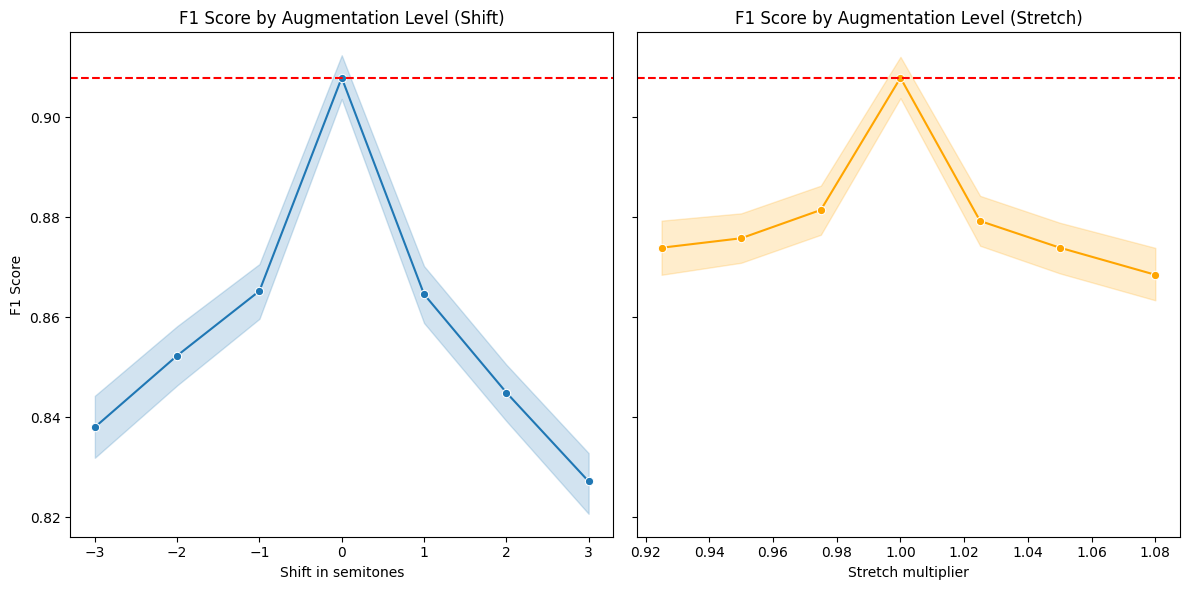

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


shift_data = df[(df["augmentation_type"] == "shift") & (df["score_type"] == "augmentation")]
stretch_data = df[(df["augmentation_type"] == "stretch") & (df["score_type"] == "augmentation")]
shift_data["augmentation_level"] = pd.to_numeric(shift_data["augmentation_level"], errors="coerce")
stretch_data["augmentation_level"] = pd.to_numeric(stretch_data["augmentation_level"], errors="coerce")

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for "shift"
sns.lineplot(
    ax=axes[0],
    data=shift_data,
    x="augmentation_level",
    y="f1_score",
    marker="o"
)
axes[0].axhline(macro_f1, color="red", linestyle="--", label=f"Macro F1 = {macro_f1}")
axes[0].set_title("F1 Score by Augmentation Level (Shift)")
axes[0].set_xlabel("Shift in semitones")
axes[0].set_ylabel("F1 Score")

# Plot for "stretch"
sns.lineplot(
    ax=axes[1],
    data=stretch_data,
    x="augmentation_level",
    y="f1_score",
    marker="o",
    color="orange"
)
axes[1].axhline(macro_f1, color="red", linestyle="--", label=f"Macro F1 = {macro_f1}")
axes[1].set_title("F1 Score by Augmentation Level (Stretch)")
axes[1].set_xlabel("Stretch multiplier")

# Adjust layout and show
plt.tight_layout()
plt.savefig('stretch_shift_aug.png')
plt.show()

## Aggregate

In [35]:
df["spread"] = df["augmentation_level"].apply(lambda x: x.count("_") // 2 if isinstance(x, str) else 0)

# Map spread values to the custom ranges
def map_shift_label(spread):
    if spread == 1:
        return "-1 to 1"
    elif spread == 2:
        return "-2 to 2"
    elif spread == 3:
        return "-3 to 3"
    return "0"  # Default label for baseline

def map_stretch_label(spread):
    if spread == 1:
        return "0.975 to 1.025"
    elif spread == 2:
        return "0.95 to 1.05"
    elif spread == 3:
        return "0.925 to 1.08"
    return "1"  # Default label for baseline

# Apply the mapping for shift and stretch
df["spread_label"] = df.apply(lambda row: map_shift_label(row["spread"]) if row["augmentation_type"] == "shift" else map_stretch_label(row["spread"]), axis=1)

# Separate the baseline data
baseline_df = df[df["score_type"] == "baseline"]

# Filter for aggregation data (including shift and stretch)
aggregation_df = df[df["score_type"] == "aggregate"]

# Merge the baseline and aggregation data on file_id to compute the change in F1 score
merged_df = pd.merge(aggregation_df, baseline_df, on="file_id", suffixes=("_agg", "_baseline"))

# Calculate the change in F1 score
merged_df["f1_change"] = (merged_df["f1_score_agg"] - merged_df["f1_score_baseline"]) * 100
merged_df["precision_change"] = (merged_df["precision_agg"] - merged_df["precision_baseline"]) * 100
merged_df["recall_change"] = (merged_df["recall_agg"] - merged_df["recall_baseline"]) * 100

spread_order_shift = ["-1 to 1", "-2 to 2", "-3 to 3"]
spread_order_stretch = ["0.975 to 1.025", "0.95 to 1.05", "0.925 to 1.08"]

# Separate shift and stretch data
shift_data = merged_df[merged_df["augmentation_type_agg"] == "shift"]
stretch_data = merged_df[merged_df["augmentation_type_agg"] == "stretch"]

### Change in precision, recall, F1 after TTA

In [38]:
# Group by spread label and calculate the average change in precision, recall, and F1 for each
shift_summary = shift_data.groupby("spread_label_agg")[["precision_change", "recall_change", "f1_change"]].mean()
stretch_summary = stretch_data.groupby("spread_label_agg")[["precision_change", "recall_change", "f1_change"]].mean()

# Combine the results into a final summary table with rows for shift and stretch methods
summary_table = pd.concat([shift_summary, stretch_summary.iloc[::-1]], keys=["Shift", "Stretch"])

# Reset the index to make it more readable
summary_table.reset_index(level=0, inplace=True)
summary_table.rename(columns={"level_0": "Method"}, inplace=True)

# Display the final summary table
print(summary_table.round(2))

                   Method  precision_change  recall_change  f1_change
spread_label_agg                                                     
-1 to 1             Shift             -0.55          -3.03      -1.77
-2 to 2             Shift             -0.78          -3.59      -2.17
-3 to 3             Shift             -0.93          -3.88      -2.39
0.975 to 1.025    Stretch             -0.83          -2.43      -1.61
0.95 to 1.05      Stretch             -0.75          -2.92      -1.80
0.925 to 1.08     Stretch             -0.65          -3.22      -1.90


### F1 change distribution after TTA

/tmp/ipykernel_30/354398648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_data["spread_label_agg"] = pd.Categorical(shift_data["spread_label_agg"], categories=spread_order_shift, ordered=True)
/tmp/ipykernel_30/354398648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stretch_data["spread_label_agg"] = pd.Categorical(stretch_data["spread_label_agg"], categories=spread_order_stretch, ordered=True)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default o

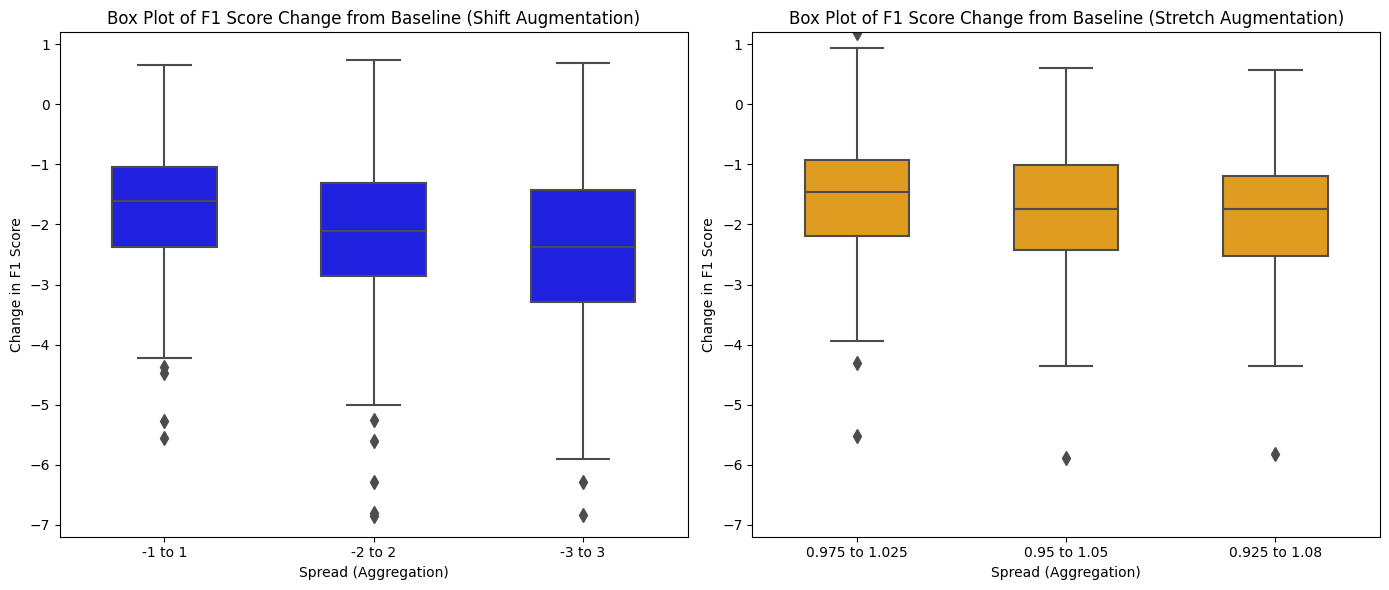

In [39]:
shift_data["spread_label_agg"] = pd.Categorical(shift_data["spread_label_agg"], categories=spread_order_shift, ordered=True)
stretch_data["spread_label_agg"] = pd.Categorical(stretch_data["spread_label_agg"], categories=spread_order_stretch, ordered=True)

# Set up the figure with two side-by-side subplots
plt.figure(figsize=(14, 6))

# Plot for shift
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.boxplot(data=shift_data, x="spread_label_agg", y="f1_change", color='blue', width=0.5, fliersize=7)
plt.ylim(-7.2, 1.2)  # Set the y-axis limits
plt.title("Box Plot of F1 Score Change from Baseline (Shift Augmentation)")
plt.xlabel("Spread (Aggregation)")
plt.ylabel("Change in F1 Score")

# Plot for stretch
plt.subplot(1, 2, 2)  # (rows, columns, index)
sns.boxplot(data=stretch_data, x="spread_label_agg", y="f1_change", color='orange', width=0.5, fliersize=7)
plt.ylim(-7.2, 1.2)  # Set the y-axis limits
plt.title("Box Plot of F1 Score Change from Baseline (Stretch Augmentation)")
plt.xlabel("Spread (Aggregation)")
plt.ylabel("Change in F1 Score")

# Display the plot
plt.tight_layout()
plt.savefig('agg_change.png')
plt.show()

### Show errors/improvments

In [58]:
def find_exact_filename(file_id, augmentation_type, spread):
    """
    Search for the exact aggregate file name in the given folder based on file_id, augmentation_type, and spread.
    """
    # Predicted number of underscores
    num_underscores = 2 + spread * 2

    # List all files in the folder
    files_in_folder = os.listdir("aggregated")

    # Search for matching files
    for file in files_in_folder:
        if file.startswith(str(file_id)) and file.endswith(".mid"):
            # Check augmentation type in file name
            if augmentation_type in file:
                # Count underscores in the file name
                if file.count("_") == num_underscores:
                    return os.path.join("aggregated", file)
    
    # Return None if no matching file is found
    return None

merged_df["filename"] = merged_df.apply(
    lambda row: find_exact_filename(row["file_id"], row["augmentation_type_agg"], row["spread_agg"]),
    axis=1
)

merged_df["ground_truth_path"] = merged_df["file_id"].apply(lambda file_id: maestro_test_true_paths[file_id])

# Filter out rows where the filename could not be found
filtered_df = merged_df[merged_df["filename"].notna()]

# Select and sort the relevant columns
sorted_scores = filtered_df[["file_id", "filename", "f1_change", "ground_truth_path", "precision_change", "recall_change"]].sort_values(
    by="f1_change", ascending=False
)

positive_f1_count = sorted_scores[sorted_scores['f1_change'] > 0].shape[0]
print(f"Number of instances where 'f1_change' is positive: {positive_f1_count}")

print("Top 10 results:")
for index, row in sorted_scores.head(10).iterrows():
    print(f"F1 Score: {row['f1_change']} {row['precision_change']} {row['recall_change']}, agg path: {row['filename']}, gt path: {row['ground_truth_path']}")

# Print the tail of the sorted DataFrame using loop
print("\nBottom 10 results:")
for index, row in sorted_scores.tail(10).iterrows():
    print(f"F1 Score: {row['f1_change']} {row['precision_change']} {row['recall_change']}, agg path: {row['filename']}, gt path: {row['ground_truth_path']}")


row = sorted_scores.iloc[0]
midi_cmp(
    row['ground_truth_path'], 
    f"maestro_transcribed/{row['file_id']}.mid", 
    row['filename'], 
    str(int(row['f1_change'])))

row = sorted_scores.iloc[-1]
midi_cmp(
    row['ground_truth_path'], 
    f"maestro_transcribed/{row['file_id']}.mid", 
    row['filename'], 
    str(int(row['f1_change'])))

Number of instances where 'f1_change' is positive: 29
Top 10 results:
F1 Score: 1.1929647338923655 2.647102030257109 -0.3605549864978186, agg path: aggregated/168_stretch_0975_1_1025.mid, gt path: /kaggle/input/themaestrodatasetv2/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_04-06_ORIG_MID--AUDIO_08_R1_2004_05_Track05_wav--1.midi
F1 Score: 0.9399714459395581 3.2108279845704413 -1.6472663139329824, agg path: aggregated/165_stretch_0975_1_1025.mid, gt path: /kaggle/input/themaestrodatasetv2/maestro-v2.0.0/2014/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.midi
F1 Score: 0.7432750283030476 2.5886954787335714 -1.5837532230974838, agg path: aggregated/29_shift_-2_-1_0_1_2.mid, gt path: /kaggle/input/themaestrodatasetv2/maestro-v2.0.0/2008/MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--3.midi
F1 Score: 0.687508449921137 2.886134603316415 -2.0580512383790994, agg path: aggregated/29_shift_-3_-2_-1_0_1_2_3.mid, gt path: /kaggle/input/themaestrodatasetv2/m

In [25]:
baseline_df = df[df["score_type"] == "baseline"][["file_id", "f1_score"]].rename(columns={"f1_score": "f1_score_baseline"})
aggregate_df = df[df["score_type"] == "aggregate"][["file_id", "f1_score", "augmentation_type", "augmentation_level", "ground_truth_midi_path"]].rename(columns={"f1_score": "f1_score_aggregate"})

# Merge baseline and aggregate data on file_id
merged_df = pd.merge(aggregate_df, baseline_df, on="file_id")

# Calculate the change in aggregate F1 score over the baseline
merged_df["f1_change"] = merged_df["f1_score_aggregate"] - merged_df["f1_score_baseline"]

# Calculate the correlation between baseline F1 score and the change
correlation = merged_df["f1_score_baseline"].corr(merged_df["f1_change"])

print(f"Correlation between baseline F1 score and change in aggregate F1 score: {correlation:.4f}")

Correlation between baseline F1 score and change in aggregate F1 score: 0.0628


/tmp/ipykernel_30/1574061314.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby("f1_change_bin")["f1_score_baseline"]


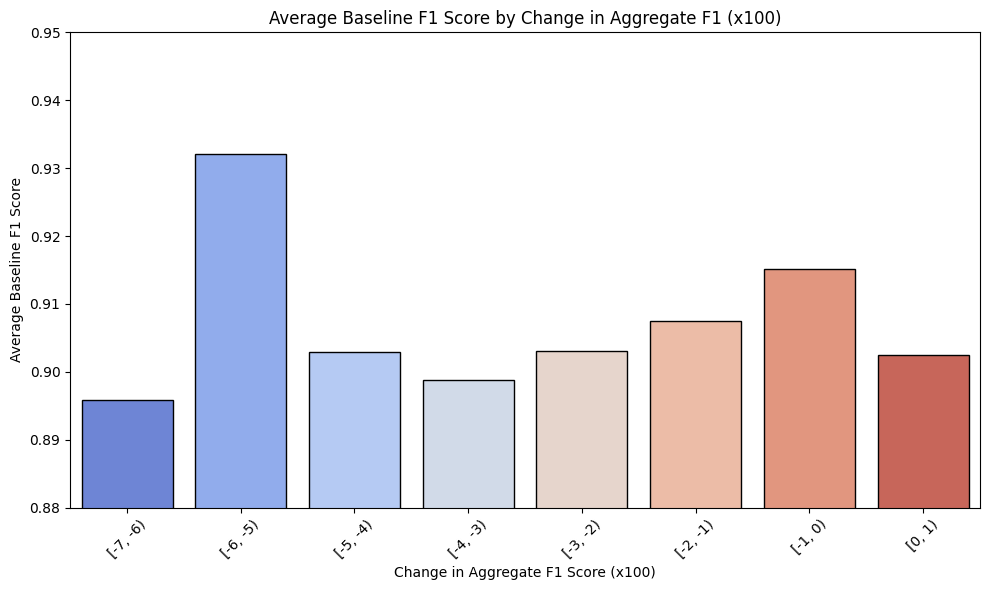

In [26]:
# Bin the f1_change values into the specified range
merged_df["f1_change_100"] = (merged_df["f1_change"] * 100).round().astype(int)
bins = range(-7, 2)  # Bins from -7 to 1 (inclusive)
merged_df["f1_change_bin"] = pd.cut(merged_df["f1_change_100"], bins=bins, right=False)

# Group by the binned values and calculate the average baseline F1 score
bin_avg_baseline = (
    merged_df.groupby("f1_change_bin")["f1_score_baseline"]
    .mean()
    .reset_index()
    .rename(columns={"f1_score_baseline": "avg_baseline_f1"})
)

# Map bins to string labels for clarity
bin_avg_baseline["f1_change_bin"] = bin_avg_baseline["f1_change_bin"].astype(str)

# Create the diverging bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bin_avg_baseline,
    x="f1_change_bin",
    y="avg_baseline_f1",
    palette="coolwarm",
    edgecolor="black"
)
plt.ylim(0.88, 0.95)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Average Baseline F1 Score by Change in Aggregate F1 (x100)")
plt.xlabel("Change in Aggregate F1 Score (x100)")
plt.ylabel("Average Baseline F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('baseline_agg_corr.png')
plt.show()

/tmp/ipykernel_30/1510296934.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby("baseline_bin")["f1_change"]


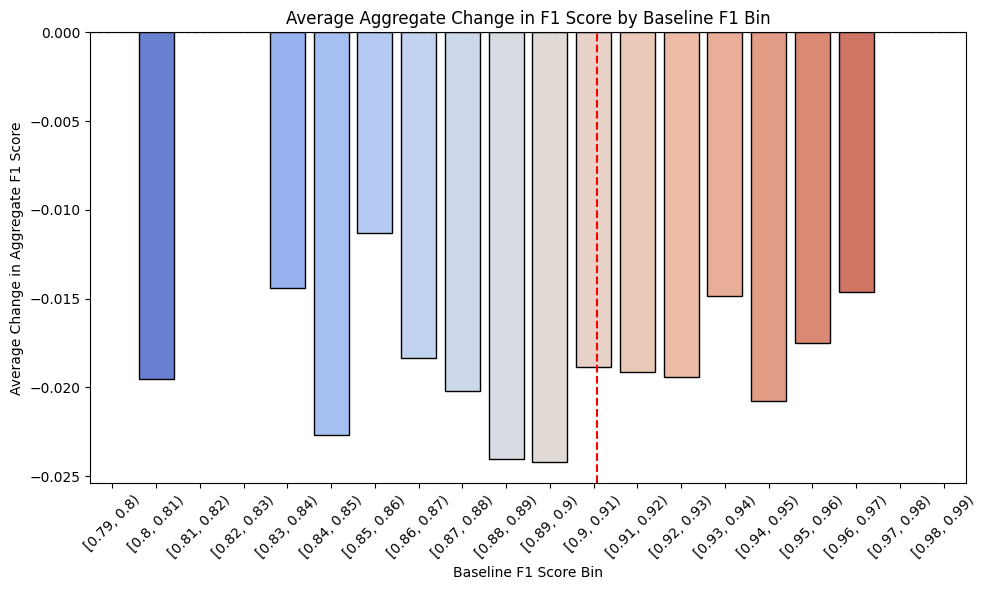

In [27]:
# Bin the baseline F1 scores into the range 0.75 to 0.95 with appropriate intervals
bins = np.arange(0.79, 1, 0.01)  # Create bins with 0.02 intervals
merged_df["baseline_bin"] = pd.cut(merged_df["f1_score_baseline"], bins=bins, right=False)

# Calculate the change in aggregate F1 over baseline
merged_df["f1_change"] = merged_df["f1_score_aggregate"] - merged_df["f1_score_baseline"]

# Group by the binned baseline F1 scores and calculate the average F1 change
bin_avg_change = (
    merged_df.groupby("baseline_bin")["f1_change"]
    .mean()
    .reset_index()
    .rename(columns={"f1_change": "avg_f1_change"})
)

# Map bins to string labels for clarity
bin_avg_change["baseline_bin"] = bin_avg_change["baseline_bin"].astype(str)

# Create the diverging bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bin_avg_change,
    x="baseline_bin",
    y="avg_f1_change",
    palette="coolwarm",
    edgecolor="black"
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(x=macro_f1*10+2, color='red', linestyle='--', linewidth=1.5, label="Macro F1 Reproduced")
plt.title("Average Aggregate Change in F1 Score by Baseline F1 Bin")
plt.xlabel("Baseline F1 Score Bin")
plt.ylabel("Average Change in Aggregate F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# TODO
- [x] Save baselines into JSON
- [x] Save single augmented performance + correlation to baseline F1
- [x] Save aggregated performance
- [ ] Explain why [0.925, 0.95, 0.975, 1, 1.025, 1.05, 1.08] and how I computed it
- [x] Compute rest of augmented files
- [x] Comment on MAPS, possible to test? Does augmentation just induce overfitting?
- [x] Show examples of the mistakes and corrections on files that improve
- [x] skicka lor beskrivning